<a href="https://colab.research.google.com/github/CS-Edwards/vse/blob/main/Weaviate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weaviate Vector Database Project
By: Candace Edwards <br>
Email: [cedward2@hawaii.edu](mailto:cedward2@hawaii.edu)

This is the final project for ICS691B: Big Data Analytics, Fall 2022.
Submitted: 12/15/22


## Project Overview:

In this project I will review the architecture of Weaviate and use Weavaite to implement my own vector search engine as a demonstration.

The data for this project is gathered by scraping the UH Manoa spring ‘23 registration page and course catalog page. Ultimately, we use course information such as the course name, course description, department and instructor to build our database objects and vectorize our data. 

#Weaviate Review

Weavaite is an open-source vector database maintained by SeMI Technologies. Weavaite is described as a ‘cloud-native, modular, real-time vector search engine built to scale your machine learning models’.
 
Weaviate is built in the Go programming language, and currently supports client libraries in Python, JavaScript and Java – in addition to Go. GraphQL is the primary query language of Weaviate, while using RESTful API for CRUD operations.
 
Weaviate is designed to leverage the speed and scale of Approximate Nearest Neighbor libraries, while supporting the expected functions necessary of a database -- including full CRUD capabilities and mutable indices in order to perform efficient: vector search, keyword search and ID based search. 


## Architecture Overview

The image below is a diagram of ‘Weaviate’s System Level Overview (Example with two modules)' sourced from Weaviate’s [documentation](https://weaviate.io/developers/weaviate/current/architecture/index.html). In this section, the diagram will guide the discussion of Weaviate’s architectural components. This section covers the following portions of the diagram: Modules, API and Persistence. Business logic is excluded from the discussion, as it is not relevant to our demonstration.

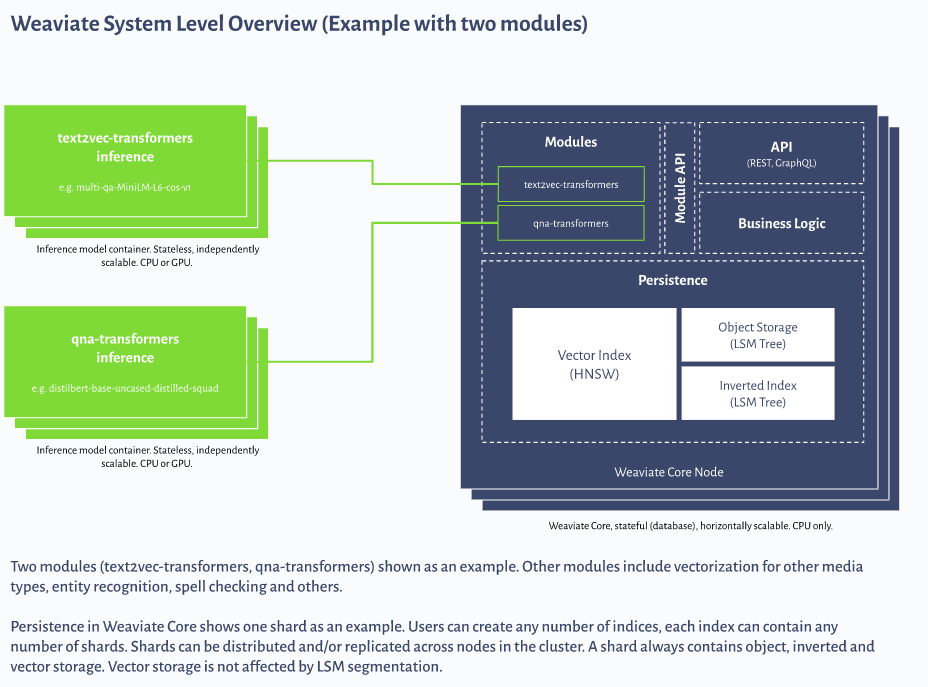

### Modules

Weavaite provides several dense retriever modules out of the box that can be used to vectorize data. Both text and images can be vectorized using the modules. Weaviate’s vectorization modules currently include: `text2vec-openai`, `text2vec-huggingface`, `text2vec-transformers`, `text2vec-contextionary`,`img2vec-neural`, `multi2vec-clip`, `ref2vec-centroid`.  The contextionary module is Weaviate’s own Weighted Mean of Word Embeddings vectorizer that creates a 300-dimensional space embedding. Other modules offer the integration of popular external models. For example, `text2vec-huggingface`, allows Hugging Face models to be integrated directly into Weaviate as the vectorizer. 


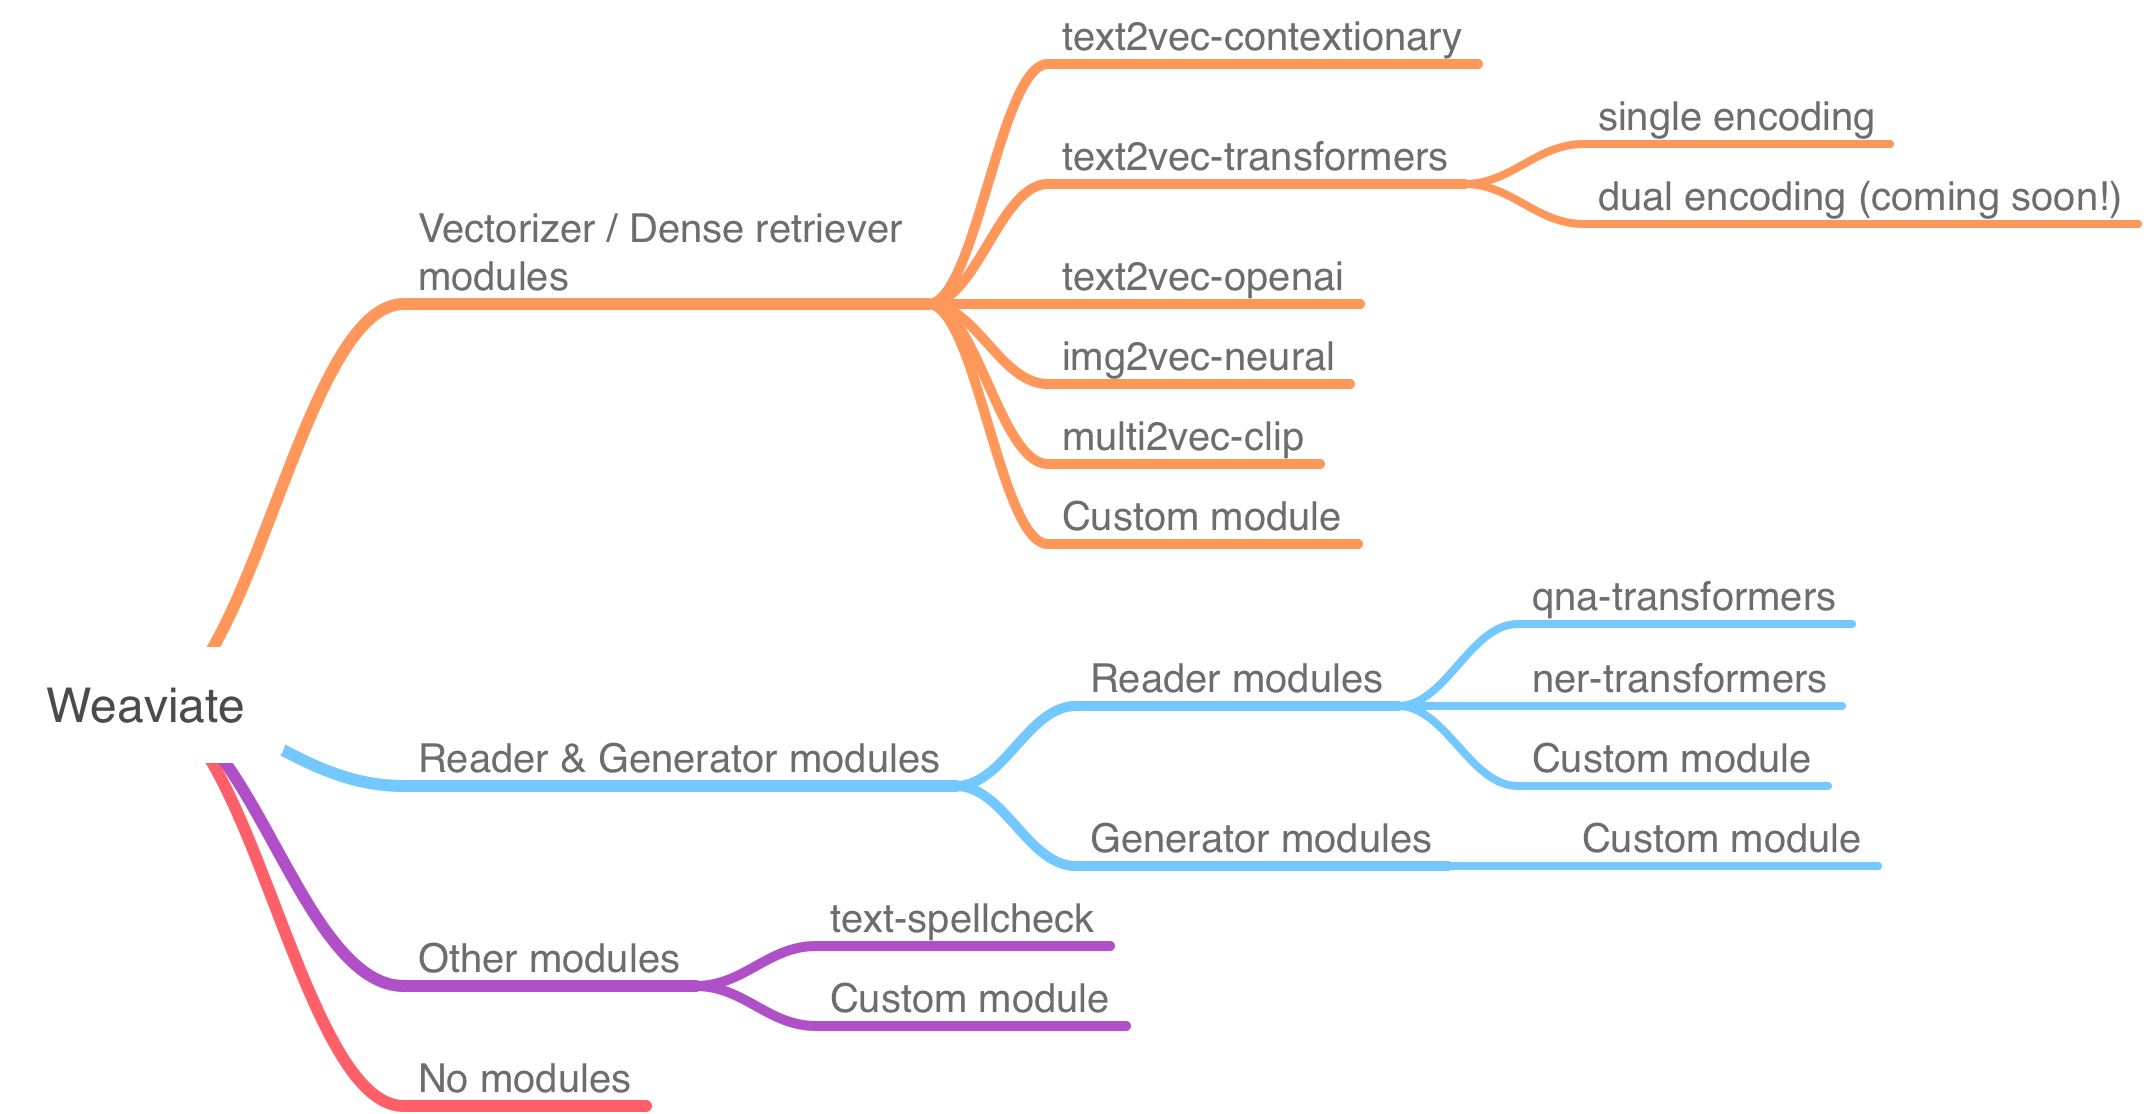

To date, `text2vec-openai`, and `text2vec-huggingface` are the only modules available (enabled) on the Weaviate Cloud Service. 

Additional modules can be used with vectorizer modules to provide further functionality in the vector database including: Question Answering, Name Entity Recognition and Summarization. Weavaite also allows for the integration of custom modules written in Go. 

**Weaviate can be used without any modules as a pure vector-native database and search engine. In this case the user must provide the vector.** 

**In our implementation of the Weaviate database, we generate our own vectors and load them into the database with the object.**


### APIs and the Weaviate Console:
Weaviate utilizes both a RESTful API and GraphQL API. The GraphQL API is used for: data search, explorative data search and meta-data analysis, while RESTful API is used for CRUD operations and Weaviate management operations. Weaviates support client libraries (Python, Java, Go and JavaScript) use both APIs ‘under the hood’.

GraphQL is the query language used to interact with Weaviate instances. According to the interface [documentation](https://weaviate.io/developers/weaviate/current/architecture/interface.html), the natural language structure of GraphQL queries, the Class and properties structure of the Weaviate data and the query filtering abilities were the key UX design considerations taken into account when developing the interface. The GraphQL design support three main functions : <br>


`Get{}` : for data search when the class name is known <br>
`Explore{}`:  to ‘fuzzy search’ when the schema and class names are unknown <br>
`Aggregate{}`: to search for metadata and do data analysis of data aggregations <br>

The Weaviate Console is a dashboard to manage clusters from the Weaviate Cloud Service. Within the Weaviate Console, the Query Module can be used to make GraphQL queries on Weaviate instances. <br>

<b> Note: In our demonstration we use the Python client to query the data. The query in Python is translated into a GraphQL query. </b>


### Persistence:


A Weaviate shard contains an object store, an inverted index and an index vector store. Weaviate allows for pre-filtered metadata search using the inverted index, and returns full objects stored in the object store. The HNSW graph is stored in the index vector store, and is discussed in detail later in this project. 

Both the object and inverted index use a Log-Structured Merge (LSM) Tree approach. LSM Trees allow for constant, O(1), data inserts by batch sequential writes of sorted data to disk. For read requests, the current memtable (in memory) is checked for the requested object. If the object is not present in the memtable, previously written segments (on disk) are checked in order of most current to ascending aged segments. Bloom filters are used to reduce accesses to segments that do not contain the object being queried. In short, if the Bloom filter key hash result is zero, the object is not present in the segment and the segment is not searched. Overall the LSM Tree implementation used in Weaviate’s current version allows for optimal write speed, which is necessary for the write-intensive CRUD operations supported by the vector database.  

The HNSW vector index is stored alongside the object and inverted index to prevent segmenting the vector index; which would have a negative impact on recall and latency during a filtered query. This is discussed in more detail later on in this project. 

In the case of the LSM trees for object storage and the inverted index, Weaviate utilizes a Write-Ahead-Log (WAL) to prevent data loss in the event of a crash. WALs are appended only files that are only marked as ‘complete’ when the LSM trees are successfully written into memory. If there is an issue, data can be recovered from the WALs. In the case of the HNSW vector index, the WAL serves as the ‘primary persistence mechanism’ in addition to a fail safe for data recovery. In the construction of the HNSW index, the calculations relating to the placement of objects and the link relationship with its neighbors are stored in the WAL. ‘Reading the WAL into memory, the HNSW index will be in the same state as it was prior to a shutdown’.


## Vector Database: Vectors and the Vector Index

In this section we discuss the core topics of the vector database -vector emeddings, similarity search,the vector index and filtered vector searches. 

### Vector Embedding

A vector embedding is a numerical representation of an object. These vector embeddings are often hyper-dimensional – more than two dimensions. The dimensionality of the embedding is dependent on the ML model used to create the vector. The model determines how to codify the object and produce a vector in hyperspace such that similar entities are relatively close to each other.

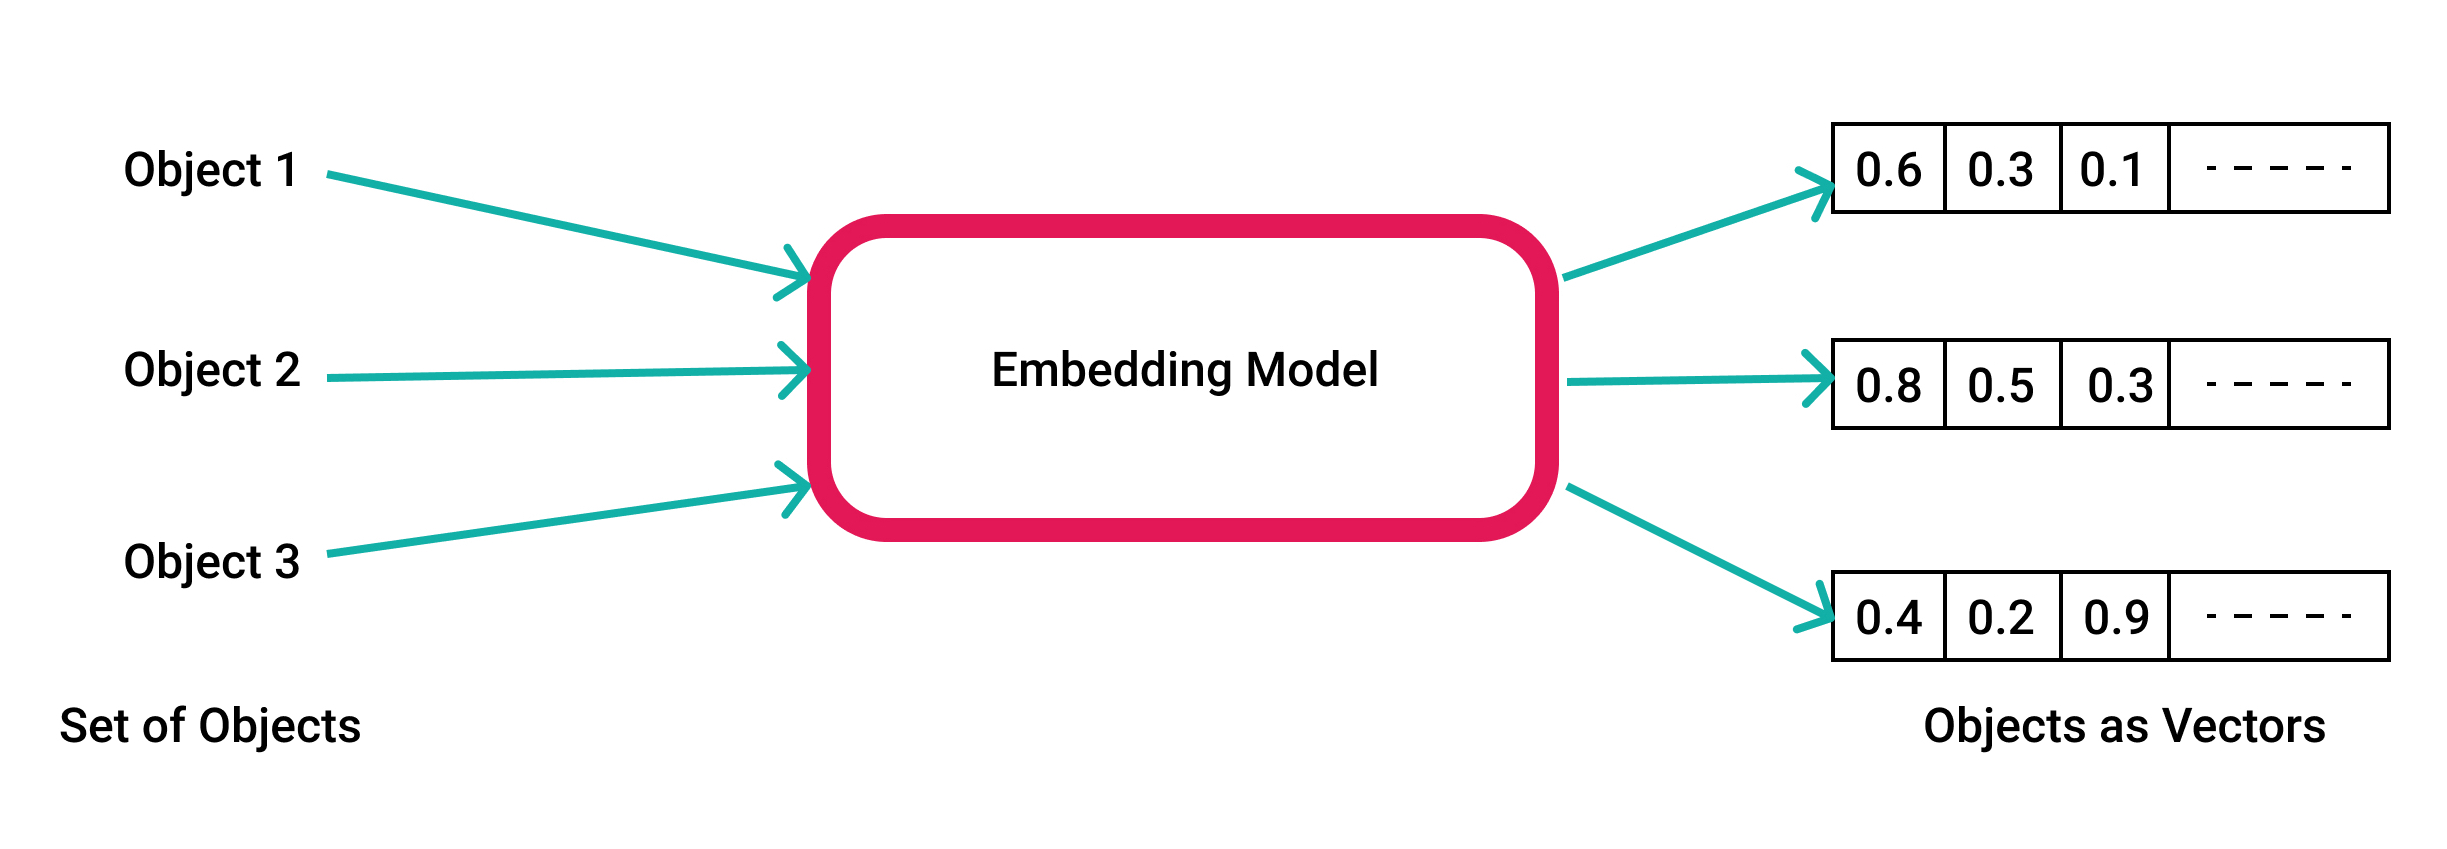
##### Image Source: [Pinecone](https://www.pinecone.io/learn/vector-embeddings/)


For this project we are using the `bert-base-nli-mean-tokens` sentence transformer model from Hugging Face, to perform a semantic similarity query  between our data objects (Courses), based on the course title, description and department. This model produces a vector embedding of 768 dimensions. 


In [ ]:
model_in = 'bert-base-nli-mean-tokens'

In [ ]:
model =  SentenceTransformer(model_in)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
sample_vec_str = 'Introduction to 3D Computer Animation  A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)'
sample_vec_str

'Introduction to 3D Computer Animation  A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)'

In [ ]:
sample_vec_embedding = model.encode([sample_vec_str])
sample_vec_embedding

array([[-2.52087355e-01,  1.02398765e+00,  5.17892659e-01,
         2.07182214e-01,  4.35276628e-01, -5.65324664e-01,
         2.43495852e-01,  1.04079813e-01,  1.07276745e-01,
        -1.10397279e-01, -1.28311947e-01,  2.53727049e-01,
         6.35129213e-01,  1.64745733e-01, -4.68095332e-01,
         4.60112840e-01, -7.58652031e-01, -7.14574516e-01,
         8.62229839e-02, -2.11045474e-01, -5.14945686e-01,
        -1.15580881e+00, -1.76512137e-01,  6.18724763e-01,
        -4.47163619e-02,  1.74594522e-01,  4.94724244e-01,
         5.24668813e-01, -4.28189695e-01, -3.43036622e-01,
        -8.43809128e-01,  1.74863562e-01,  6.21227324e-01,
        -8.08930516e-01,  5.56665719e-01,  6.68312371e-01,
         6.12137467e-02,  7.24730730e-01,  5.75876355e-01,
         3.36582184e-01, -1.46078944e-01, -2.38020971e-01,
         4.99893308e-01, -5.25775373e-01, -1.11525130e+00,
        -1.29245088e-01,  2.49865115e-01,  2.69043475e-01,
        -3.05328984e-02, -2.65406996e-01, -4.82159376e-0

In [ ]:
sample_vec_embedding.shape

(1, 768)

### Vector Similarity Search: kNN and ANN

Our vector database uses an index to store the vector embeddings we intend to search. The purpose of the search is to locate and return vectorized objects similar to that of our vectorized query. The primary trade-offs to consider when selecting an index are: speed search (latency) and search quality (recall). An additional consideration is that of cost in terms of memory. 

K nearest neighbor (kNN), a popular vector search algorithm, provides excellent accuracy in a search. kNN calculates the distance between the query vector and every vector within the database to return the closest k neighbors. kNN is a flat (brute force) index approach. The issue with kNN is that it scales linearly depending on the size of the dataset. A search query will take O(N) time, since all vectors embedding are considered. This is not ideal given the large sizes of dataset often seen in big data. 

To make search faster on large datasets, vector size can be reduced and/or search scope can be reduced. In either approach we sacrifice search accuracy for the sake of speed, to perform an Approximate Nearest Neighbor (ANN) search. 

There are several algorithms available to implement ANN including: Spotify’s [ANNOY](https://github.com/spotify/annoy) (Approximate Nearest Neighbors Oh Yeah) a tree-based ANN search, Facebook’s [FAISS](https://github.com/facebookresearch/faiss) (Facebook AI Similarity Search) a cluster- based ANN search, and HNSW (Hierarchical Navigable Small Worlds) a graph-based ANN search.

### Vector Index: Hierarchical Navigable Small World (HNSW):

Weavaite’s default index vector type is a customized HNSW implementation of ANN. HNSW is a top performing index for vector similarity search that delivers both fast search speeds and quality recall. 

The original paper for HNSW can be found [here](https://arxiv.org/ftp/arxiv/papers/1603/1603.09320.pdf). In summary, HNSW graphs are a Navigable Small World (NSW) modified to include the layer structure of a probability skip list. Navigable small world models are defined as any network with (poly/)logarithmic complexity using greedy routing.  As a proximity graph, NSW structures contain both long-range and short-range link lengths, and each node has knowledge of their (local) neighbors in a ‘friend list’ .The link length variation produces the logarithmic search complexity. Hierarchical Navigable Small Worlds graphs, as evidenced by the name, extends the idea of a navigable small world by adding hierarchy based on the length of the links between the nodes where the top layer contains the longest links and the bottom layer contains the shortest. 

A search within an HSNW graph begins at the top layer (entry layer) with the longest links. This is a global search of the network; with the fewest nodes to consider. We traverse the entry layer until we find the local minimum, which is the node in that particular layer that is ‘closest’ to our query. We then follow that node to the next, more densely connected  sub-layer, for the local minimum. This process continues until we reach the base layer 0, and find the nearest neighbor to our vector query. 


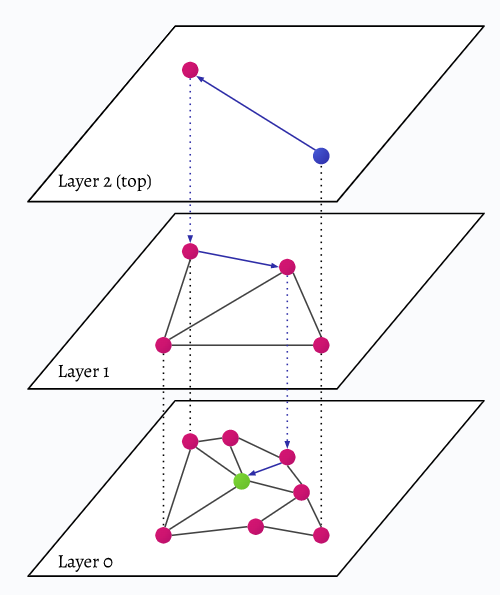

Weaviate allows for custom configuration of HNSW. Several distance metrics are supported including: Euclidean distance (l2-squared), Hamming and Manhattan. The default distance metric is cosine distance. Several other HSNW parameters can be custom configured for optimization including: <br>


`ef `: The number of entry points explored between layers during the search<br>
`efConstruction`: The number of entry points explored during index construction <br>
`maxConnections`: The maximum number of neighbors each node will connect to <br>

The `ef`, `efConstruction` and `maxConnection` parameters can be increased to improve the search quality. However, search quality is improved at the cost of time. Increasing `ef` and `maxConnection` for the sake of accuracy will also increase the query time. Increasing `efConstruction`, increases construction time. Weavaite documentation provides an in-depth exploration of the parameter effect on performance, [here](https://weaviate.io/developers/weaviate/current/benchmarks/ann.html#sift1m-1m-128d-vectors-l2-distance).

<b> Given the relatively small size of our demo dataset, we utilize the default index setting set by Weaviate in our database. </b>


### Filtered Vector Search

In general, there are two approaches to filtering a vector search based on its associated metadata: pre-filtering vs post-filtering. 

In post-filtering, the vector search query is performed first and metadata filters are applied to the resulting vector search query. The pitfall of this approach is that given the results of the vector query, there may not exist any results that fit the criteria of the subsequent filter. In other words, no matches are returned, even though matches could exist somewhere in the dataset. 

Pre-filtering provides a solution to the problem mentioned above. In pre-filtering the metadata filters are applied first ensuring that there will be matches that fit the filter criteria, then the ANN vector search is applied to the restricted (pre-filtered) data. Note, in some of the literature on pre-filtering vector searches, it is stated that once the data is pre-filtered the vector search must be conducted in a brute force manner, losing the efficiency of approximation. This is not the case for Weaviat’es pre-filter search.

As noted earlier in the ‘Architecture Overview’, Weaviate’s inverted index is next to the HNSW index in storage. This configuration allows for an efficient pre-filter search process where , according to the [documentation](https://weaviate.io/developers/weaviate/current/architecture/prefiltering.html):

1. An inverted index (similar to a traditional search engine) is used to create an allow-list of eligible candidates. This list is essentially a list of uint64 ids, so it can grow very large without sacrificing efficiency.


2. A vector search is performed where the allow-list is passed to the HNSW index. The index will move along any node’s edges normally, but will only add ids to the result set that are present on the allow list. The exit conditions for the search are the same as for an unfiltered search: The search will stop when the desired limit is reached and additional candidates no longer improve the result quality.

In other words, pre-filtering in Weaviate, maintains the vector search efficiency of the HNSW, Approximate Nearest Neighbor implementation; preserving both the recall (~80% and above)  and latency (sub 50 ms) performance of the query. Weaviate also implements a ‘Flat-Search Cutoff’, where the vector search automatically switches to a flat search to enhance performance. The default cutoff is ~15% of the dataset size. The logic being that if a filtered search is already restricted to 15% of the dataset size, HNSW (ANN) performance is closer to that of a flat search (KNN); and therefore it is more efficient to switch to a flat search outright.
 
A full exploration of effects of prefiltering on recall and latency performance can be viewed [here](https://towardsdatascience.com/effects-of-filtered-hnsw-searches-on-recall-and-latency-434becf8041c). Within Weaviate, the cutoff can be configured in the `vectorIndexConfig` settings. 

<b> For the sake of this demonstration, we use the default cutoff setting. </b>


# Vector Database Demonstration

In this section we create our Weaviate vector database.

#### Code: Library Installs and Imports

In [ ]:
import sys
!{sys.executable} -m pip install weaviate-client==3.0.0
!{sys.executable} -m pip install torch 
!{sys.executable} -m pip install transformers 
!{sys.executable} -m pip install sentence-transformers
!{sys.executable} -m pip install nltk 
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install scipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from getpass import getpass
import weaviate
from weaviate.wcs import WCS
from weaviate.batch import Batch
import torch
import uuid
import tqdm
import numpy as np
import csv
import re
import json
import pandas as pd
from tqdm.notebook import trange, tqdm
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from transformers import AutoModel, AutoTokenizer
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer

##viz
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Data and Vectors

This section contains the data we will work with to create our vector database. 
 


### Data:
`data` contains the resulting dataframe from scraping the University of Hawaii Manoa course descriptions and Spring ‘23 registration pages for relevant information. After the data was scraped from the site, the registration and description dataframes were inner joined on the `course`,and then de-duplicated. The final dataframe was saved to a csv from the `data_df.csv`.  
 
Note: Courses with the same `course_name` and `course` with different `Instructor` are not considered duplicates(ie. `ACM 310` in the dataframe).

In [ ]:
data = pd.read_csv('data/data_df.csv')
data

,Unnamed: 0,course,Credits,Instructor,Department,course_name,description,vec_str
0,0,ACM 215,3,J F Parente,Academy for Creative Media (ACM),Introduction to 3D Computer Animation,A basic overview of the 3D animation productio...,Introduction to 3D Computer Animation A basic...
1,4,ACM 216,3,L Margulies,Academy for Creative Media (ACM),Fundamentals of Animation,Introduction to traditional styles and methods...,Fundamentals of Animation Introduction to tra...
2,8,ACM 255,3,A H Ladner,Academy for Creative Media (ACM),Introduction to Cinema and Digital Media,"Introduction to the study of cinema: history, ...",Introduction to Cinema and Digital Media Intr...
3,16,ACM 310,3,S E Schimmel,Academy for Creative Media (ACM),Cinematic Narrative Production,Production-intensive course with collaborative...,Cinematic Narrative Production Production-int...
4,18,ACM 310,3,F Titz,Academy for Creative Media (ACM),Cinematic Narrative Production,Production-intensive course with collaborative...,Cinematic Narrative Production Production-int...
...,...,...,...,...,...,...,...,...
2460,11240,ZOOL 710,2-4,M A Butler,Zoology (ZOOL),Topics in Biometry,Selected advanced topics in experimental desig...,Topics in Biometry Selected advanced topics i...
2461,11246,ZOOL 719,1-6,P B Marko,Zoology (ZOOL),Topics in Systematics and Evolution,Selected problems of current or historic inter...,Topics in Systematics and Evolution Selected ...
2462,11249,ZOOL 719,1-6,K Cole,Zoology (ZOOL),Topics in Systematics and Evolution,Selected problems of current or historic inter...,Topics in Systematics and Evolution Selected ...
2463,11252,ZOOL 719,1-6,M A Butler,Zoology (ZOOL),Topics in Systematics and Evolution,Selected problems of current or historic inter...,Topics in Systematics and Evolution Selected ...


### Vectors:

The `vec_str` column is a concat of the `course_name`,`description`, and `Department`. The text in the `vec_str` column is used to create the vector embedding.

As mentioned above, we will use Hugging Face's sentence transformed `` to vectorize the data. 

In [ ]:
data.vec_str[1]

'Fundamentals of Animation  Introduction to traditional styles and methods of hand drawn 2D, digital, and stop motion animation through theory and practice. A-F only. Pre: 255 (or concurrent) and ART 113, or consent. Academy for Creative Media (ACM)'

In [ ]:
course_vecs_list = data['vec_str'].values.tolist()

In [ ]:
len(course_vecs_list)

2465

In [ ]:
course_vecs_list[:5]


['Introduction to 3D Computer Animation  A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)',
 'Fundamentals of Animation  Introduction to traditional styles and methods of hand drawn 2D, digital, and stop motion animation through theory and practice. A-F only. Pre: 255 (or concurrent) and ART 113, or consent. Academy for Creative Media (ACM)',
 'Introduction to Cinema and Digital Media  Introduction to the study of cinema: history, aesthetics, and cultural impact. A-F only. Academy for Creative Media (ACM)',
 'Cinematic Narrative Production  Production-intensive course with collaborative as well as individual projects. Theories and application of basic digital cinema productions, including camera, lighting, sound, and editing. ACM majors only. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)',
 'Cinematic Narrative P

#### Vector Embeddings:

The following cell creates embeddings for the 2465 documents in the `course_vec_list`. Running this cell takes approximately 15 mins. 

The embeddings were generated in a previous run of this model and saved as `embeddings.npy`, in the `data/` folder. 

In [ ]:
#course_vecs = model.encode(course_vecs_list)
#np.save('data/embeddings',course_vecs)

In [ ]:
course_vecs = np.load('data/embeddings.npy')

In [ ]:
course_vecs.shape

(2465, 768)

## Course Object and Schema

For our demonstration we construct a `course_object`, from each row in the `data` dataframe. Weavaite's schema structure is inspired by the Resource Description Framework Schema (RDF)'s Class/property structure. 

In our vector database, the only Class is our `Course`, which contains the following properties:


*   courseID
*   courseName
*   description
*   credits
*   instructor
*   department

As demonstrated below, the `course_object` is a simple dictionary. 

In [ ]:
sample_course_object = {
    'courseID':data.iloc[0]['course'],
    'courseName':data.iloc[0]['course_name'],
    'description':data.iloc[0]['description'],
    'credits':int(data.iloc[0]['Credits']), #cast as int for schema
    'instructor':data.iloc[0]['Instructor'],
    'department':data.iloc[0]['Department']

}
sample_course_object

{'courseID': 'ACM 215',
 'courseName': 'Introduction to 3D Computer Animation ',
 'description': 'A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent).',
 'credits': 3,
 'instructor': 'J F Parente',
 'department': 'Academy for Creative Media (ACM)'}

### Schema:

In our `course_schema` below, we implement the Class/property structure for the vector database. Since we are not using any of Weaviate's modules and providing our own vector embeddings, the `vectorizer` property is set to `none`. 

As noted in the sections above, for this demonstration we are utilizing Weaviate's default configurations, therefore our schema is straightforward. However, the schema is where most of the custom configurations are set for the database. The previously discussed `vectorIndexConfig` and module selections, along with many other available configuration options are set in the schema. 

In [ ]:
course_schema = {
     "classes": [{
                    "class": "Course",
                    "description": "A Course class to store: course_name, description, credits, instructor, department",
                    "vectorizer": "none", # explicitly tell Weaviate not to vectorize anything, we are providing the vectors ourselves through our BERT model
                    "properties": [{
                        "dataType": [
                          "string"
                        ],
                        "description": "The deptarment and number of the course",
                        "name": "courseID"
                      },
                      {
                        "dataType": [
                          "text"
                        ],
                        "description": "The course description from catalog",
                        "name": "description"
                      },{
                        "dataType": [
                          "string"
                        ],
                        "description": "The name of the course",
                        "name": "courseName"
                      },
                      {
                        "dataType": [
                          "int"
                        ],
                        "description": "Number of credits for the course",
                        "name": "credits"
                      },
                      {
                        "dataType": [
                          "string"
                        ],
                        "description": "Instructor of this course",
                        "name": "instructor"
                      },
                      {
                        "dataType": [
                          "string"
                        ],
                        "description": "Academic department of this course",
                        "name": "department"
                      }]
            }]}

## Weaviate Database Instance

To set up the out Weaviate database via Weaviate Cloud Service, we first connect to the client. Note, for this demostration I am utilizing the free sandbox tier which has an object limit of 10k, and approximatly a month of free cloud service before the instance is automatically terminated.

If you are viewing this notebook after January 11, 2023, the instance will no longer be available. 

### Connect to Client

In this section we connect to Weaviate Cloud using the Python client library, and spin our `course-search-instance` cluster for the database.

In [ ]:
my_credentials = weaviate.auth.AuthClientPassword(username=input("User name: "), password=getpass('Password: '))


User name: cedward2@hawaii.edu
Password: ··········


In [ ]:
my_wcs = WCS(my_credentials)

In [ ]:
cluster_name = 'course-search-instance'
weaviate_url = my_wcs.create(cluster_name)
weaviate_url

'https://course-search-instance.semi.network'

In [ ]:
my_wcs.is_ready(cluster_name)

True

In [ ]:
client = weaviate.Client(weaviate_url)

In [ ]:
client.schema.delete_all() # delete all classes
client.schema.get()

{'classes': []}

### Load Schema

In this seaction we load our schema to the database and view the schema. 

In [ ]:
client.schema.create(course_schema)

In [ ]:
client.schema.get()

{'classes': [{'class': 'Course',
   'description': 'A Course class to store: course_name, description, credits, instructor, department',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'properties': [{'dataType': ['string'],
     'description': 'The deptarment and number of the course',
     'name': 'courseID',
     'tokenization': 'word'},
    {'dataType': ['text'],
     'description': 'The course description from catalog',
     'name': 'description',
     'tokenization': 'word'},
    {'dataType': ['string'],
     'description': 'The name of the course',
     'name': 'courseName',
     'tokenization': 'word'},
    {'dataType': ['int'],
     'description': 'Number of credits for the course',
     'name': 'credits'},
    {'dataType': ['string'],
     'description': 'Instructor of this course',
     'name': 'instructor',
     'tokenization': 'word'},
    {'dataType': [

### Load Objects

In this section we first create a test object to load into that database to ensure the object and schema are working the way we intend. First we validate a sample object using `client.data_object.validate()` provided by the Python client. A successful validation will yield a result of `{'error': None, 'valid': True}`. The we load the sample object to our database. A successful load will return the objects `uuid`.



In [ ]:
i=0

In [ ]:
def generate_uuid_mod(class_name: str, identifier: str, int:i,
                  test: str = 'teststrong') -> str:
    """ Generate a uuid based on an identifier
    :param identifier: characters used to generate the uuid
    :type identifier: str, required
    :param class_name: classname of the object to create a uuid for
    :type class_name: str, required
    """
    test = 'overwritten'
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, class_name + identifier+str(i)))

In [ ]:

def add_course(batch, df,vec,i):

  #print('create object')
  try:
    course_object = {
      'courseID':df['course'],
      'courseName':df['course_name'],
      'description':df['description'],
      'credits':int(df['Credits']),
      'instructor':df['Instructor'],
      'department':df['Department']
    } 
  except ValueError:
    #print(ValueError)
    course_object = {
      'courseID':df['course'],
      'courseName':df['course_name'],      
      'description':df['description'],
      'credits':2,
      'instructor':df['Instructor'],
      'department':df['Department']
    } 

  #print('create_uuid')
  course_id = generate_uuid_mod('Course',df['course'],i)
  #print(course_id)

  #print('add to batch')


  #print(course_object)
  #print(course_id)
  #print(vec)
  try:
    batch.add_data_object(
        data_object = course_object,
        class_name = 'Course',
        uuid = course_id,
        vector = vec
    )
  except:    
    print('UnexpectedStatusCodeException')
    print(course_object, course_id)
    pass


  


**Test Load**

In [ ]:
sample_course_object

{'courseID': 'ACM 215',
 'courseName': 'Introduction to 3D Computer Animation ',
 'description': 'A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent).',
 'credits': 3,
 'instructor': 'J F Parente',
 'department': 'Academy for Creative Media (ACM)'}

In [ ]:
course_id = generate_uuid_mod('Course',data.iloc[0]['course'],0)
course_id

'20c5e769-dc6f-5a1a-aa40-8468732e4a16'

In [ ]:
#validate object
result = client.data_object.validate(
    data_object=sample_course_object,
    class_name='Course',
    uuid = course_id,
    
)

In [ ]:
result

{'error': None, 'valid': True}

In [ ]:
client.data_object.create(
    data_object=sample_course_object,
    class_name='Course',
    uuid = course_id,
    vector = course_vecs[0]
)

'20c5e769-dc6f-5a1a-aa40-8468732e4a16'

In [ ]:
#Successful load ; uuid returned (above)
#query db by uuid to view 
client.data_object.get(course_id, with_vector=False)


{'class': 'Course',
 'creationTimeUnix': 1670912718445,
 'id': '20c5e769-dc6f-5a1a-aa40-8468732e4a16',
 'lastUpdateTimeUnix': 1670912718445,
 'properties': {'courseID': 'ACM 215',
  'courseName': 'Introduction to 3D Computer Animation ',
  'credits': 3,
  'department': 'Academy for Creative Media (ACM)',
  'description': 'A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent).',
  'instructor': 'J F Parente'},
 'vectorWeights': None}



---

<b> Batch Load </b> <br>
After the successful test load, we are ready to load all of our objects to the database, using some help function to create `uuid` so for each object and orchastrate the `batch` load process. 

The batch is configured to load 100 objects at a time. 

In [ ]:
client.batch.configure(
    batch_size = 100,
    callback = None
)

In [ ]:
batch = client.batch

In [ ]:
#db already loaded 12/12/22
#for i in range(len(data)):
#  add_course(batch,data.iloc[i],course_vecs[i],i)


In [ ]:
result = client.query.get(class_name='Course', properties=["courseName","instructor"])\
    .with_limit(3000)\
    .do()

In [ ]:
print(type(result))

<class 'dict'>


In [ ]:
print(f"Number of courses returned: {len(result['data']['Get']['Course'])}")
#result

Number of courses returned: 1100


Note: For this instance, the Batch load encountered an error [UnexpextedStatusCodeException](https://weaviate-python-client.readthedocs.io/en/stable/weaviate.html#weaviate.UnexpectedStatusCodeException) and only 44% of the objects are acutally loaded into the database. As evidenced by the `Number of courses returned: 1100`, that database should have 2465 objects given the size of our dataframe. The vector database, works for the sake of the demonstration, but the bug is noted and will be fixed.  

## Semantic Search Queries

We are now ready to perform queries on our database! In the first query we perform a sementic search to find courses near `cooking class`.

In [ ]:
query = 'cooking class'
q_vec = model.encode(query)

nearVec= {"vector":q_vec}
res = client.query.get(class_name='Course', properties=["courseName","instructor","department"])\
    .with_limit(5)\
    .with_near_vector(nearVec)\
    .do()

res

{'data': {'Get': {'Course': [{'courseName': 'Introduction to Food Preparation ',
     'department': 'Food Science & Human Nutrition (FSHN)',
     'instructor': 'L J Hackney'},
    {'courseName': 'Food, Culture, and Empire in U.S. and Hawai‘i ',
     'department': 'Ethnic Studies (ES)',
     'instructor': 'M Koikari'},
    {'courseName': 'Food, Health, and Society ',
     'department': 'Anthropology (ANTH)',
     'instructor': 'E Saethre'},
    {'courseName': 'Food Preparation Lab ',
     'department': 'Food Science & Human Nutrition (FSHN)',
     'instructor': 'L J Hackney'},
    {'courseName': 'Field Experience ',
     'department': 'Food Science & Human Nutrition (FSHN)',
     'instructor': 'S L Breshears'}]}}}

### Basic Search:

Click [here](https://link.semi.technology/3WeEsQC) to the sample a basic query live from the Weavaite Console. This cluster instance via Weaviate Cloud Service expires 1/11/23.

Snapshot of the Sample Query:
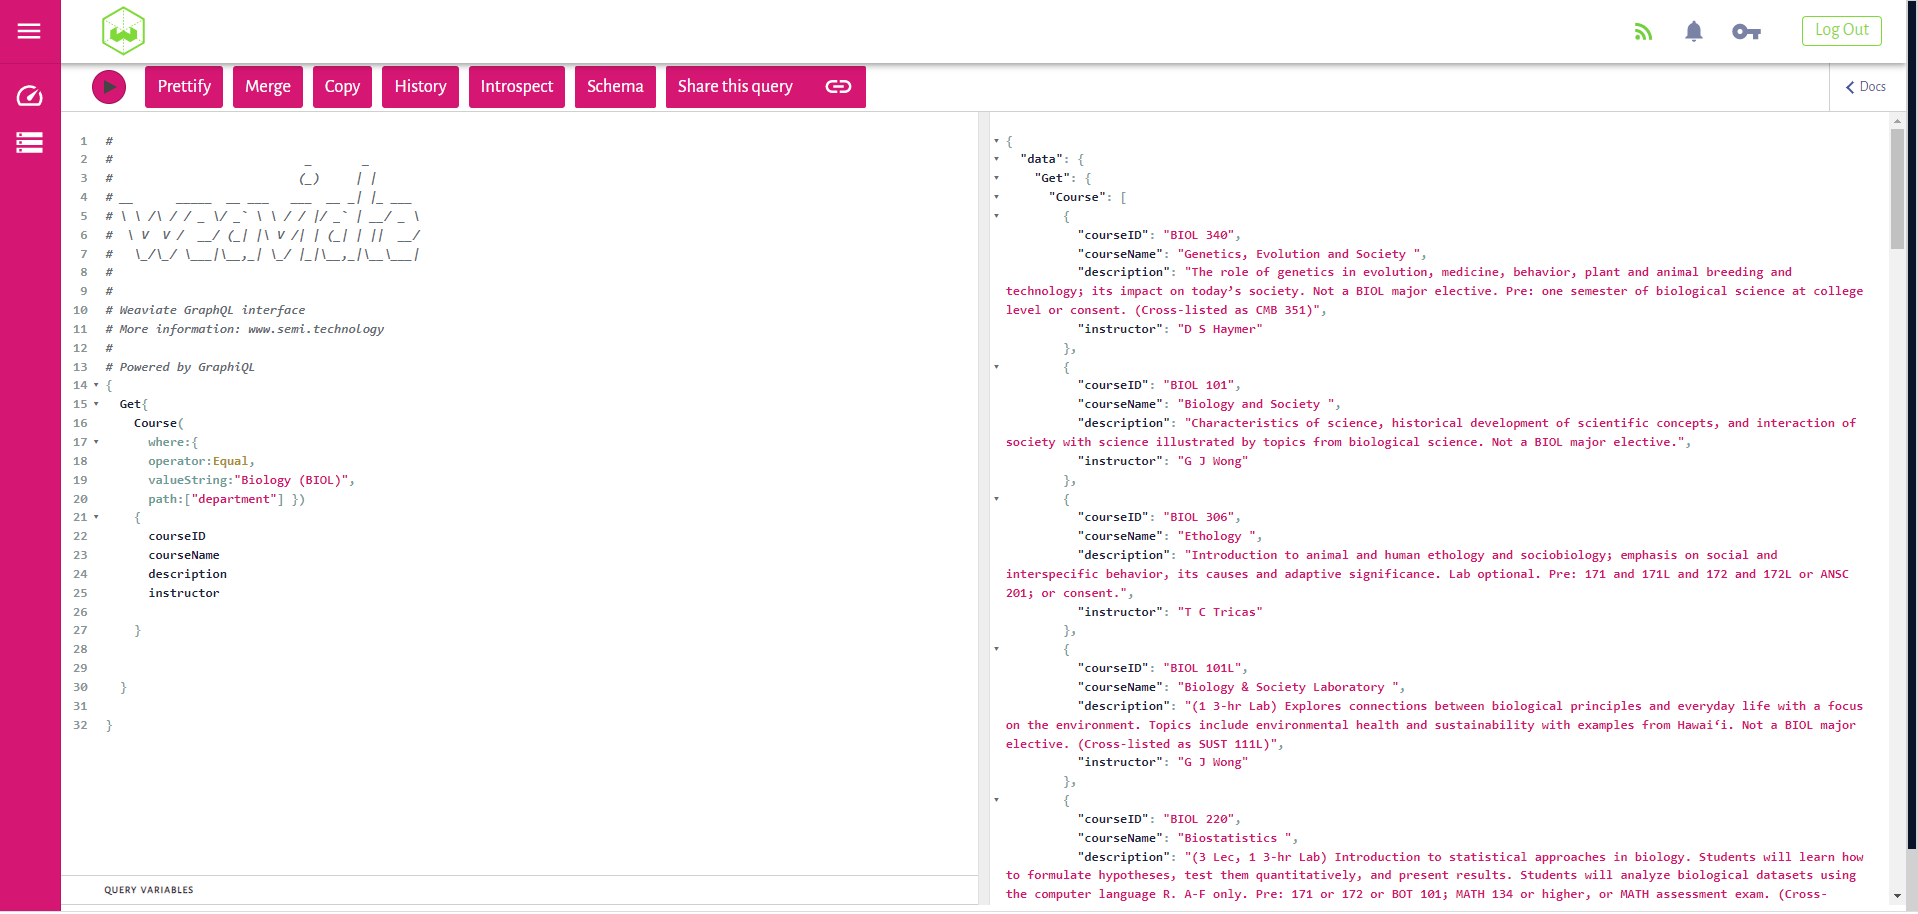

### Vector Search:

This is a vector search query within the Python client. We first vectorize our query `climate change` and pass the vector into our GET request for the database. The database returns the top five hits. 

In [ ]:
query = 'climate change'
q_vec = model.encode(query)

nearVec= {"vector":q_vec}
res = client.query.get(class_name='Course', properties=["courseName","instructor","department","credits"])\
    .with_limit(5)\
    .with_near_vector(nearVec)\
    .do()

res

{'data': {'Get': {'Course': [{'courseName': 'Environment, Resources and Society ',
     'credits': 3,
     'department': 'Geography & Environment (GEO)',
     'instructor': 'S Kandikuppa'},
    {'courseName': 'Tropical Climate and Weather ',
     'credits': 3,
     'department': 'Atmospheric Sciences (ATMO)',
     'instructor': 'Y Wang'},
    {'courseName': 'Stable Isotope Biogeochemistry ',
     'credits': 3,
     'department': 'Earth Sciences (ERTH)',
     'instructor': 'B Popp'},
    {'courseName': 'Applied Atmospheric Dynamics ',
     'credits': 3,
     'department': 'Atmospheric Sciences (ATMO)',
     'instructor': 'Y Chen'},
    {'courseName': 'Sedimentary Geochemistry ',
     'credits': 3,
     'department': 'Earth Sciences (ERTH)',
     'instructor': 'K C Ruttenberg'}]}}}

### Filtered Search: Vector and Scalar

Click [here](https://console.semi.technology/console/query#weaviate_uri=https://course-search-instance.semi.network&graphql_query=%23%20%0A%23%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20_%20%20%20%20%20%20%20_%20%20%20%20%20%20%20%20%0A%23%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20(_)%20%20%20%20%20%7C%20%7C%20%20%20%20%20%20%20%0A%23%20__%20%20%20%20%20%20_____%20%20__%20___%20%20%20___%20%20__%20_%7C%20%7C_%20___%20%20%0A%23%20%5C%20%5C%20%2F%5C%20%2F%20%2F%20_%20%5C%2F%20_%60%20%5C%20%5C%20%2F%20%2F%20%7C%2F%20_%60%20%7C%20__%2F%20_%20%5C%20%0A%23%20%20%5C%20V%20%20V%20%2F%20%20__%2F%20(_%7C%20%7C%5C%20V%20%2F%7C%20%7C%20(_%7C%20%7C%20%7C%7C%20%20__%2F%20%0A%23%20%20%20%5C_%2F%5C_%2F%20%5C___%7C%5C__%2C_%7C%20%5C_%2F%20%7C_%7C%5C__%2C_%7C%5C__%5C___%7C%20%0A%23%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%0A%23%20%0A%23%20Weaviate%20GraphQL%20interface%0A%23%20More%20information%3A%20www.semi.technology%0A%23%0A%23%20Powered%20by%20GraphiQL%0A%7B%0A%20%20Get%7B%0A%20%20%20%20Course(%0A%20%20%20%20%20%20nearVector%3A%7B%0A%20%20%20%20%20%20%20vector%3A%20%5B%201.94768399e-01%2C%20-3.71358424e-01%2C%20%201.08540845e%2B00%2C%20%203.76903832e-01%2C%0A%20%20%20%20%20%20%20%203.49149108e-02%2C%20-3.46675366e-01%2C%20%201.10240877e-01%2C%20%201.87290967e-01%2C%0A%20%20%20%20%20%20%20%201.82423115e-01%2C%20-4.79313940e-01%2C%20%202.90813625e-01%2C%20%203.92057270e-01%2C%0A%20%20%20%20%20%20%20-4.20621485e-01%2C%20%209.72537577e-01%2C%20%208.73356819e-01%2C%20-3.36560726e-01%2C%0A%20%20%20%20%20%20%20-1.08877850e%2B00%2C%20%202.75091499e-01%2C%20-3.97552431e-01%2C%20-5.83044179e-02%2C%0A%20%20%20%20%20%20%20%204.94397670e-01%2C%20%201.95208371e-01%2C%20%203.69002447e-02%2C%20-1.62723005e-01%2C%0A%20%20%20%20%20%20%20%202.81666785e-01%2C%20-7.01882958e-01%2C%20-4.83613402e-01%2C%20-7.59421825e-01%2C%0A%20%20%20%20%20%20%20-1.52744040e-01%2C%20%201.35545164e-01%2C%20-1.25115156e-01%2C%20%208.60342860e-01%2C%0A%20%20%20%20%20%20%20-6.41994119e-01%2C%20%203.66976231e-01%2C%20-3.38728189e-01%2C%20%203.03866088e-01%2C%0A%20%20%20%20%20%20%20-1.11271214e%2B00%2C%20-5.60326517e-01%2C%20%202.04754397e-02%2C%20%202.92722315e-01%2C%0A%20%20%20%20%20%20%20-1.97880819e-01%2C%20-2.90008634e-01%2C%20%203.67715694e-02%2C%20%206.92606926e-01%2C%0A%20%20%20%20%20%20%20-6.86996937e-01%2C%20-3.06781977e-02%2C%20%202.10884154e-01%2C%20%205.67316413e-01%2C%0A%20%20%20%20%20%20%20%201.92357711e-02%2C%20-1.39489818e%2B00%2C%20-9.87413645e-01%2C%20-1.36320934e-01%2C%0A%20%20%20%20%20%20%20%208.57637703e-01%2C%20%205.08593440e-01%2C%20-3.56703818e-01%2C%20%206.18237674e-01%2C%0A%20%20%20%20%20%20%20-7.99934864e-02%2C%20-7.82829046e-01%2C%20-2.83238918e-01%2C%20%208.81938994e-01%2C%0A%20%20%20%20%20%20%20-1.35836631e-01%2C%20-4.35444295e-01%2C%20-6.52065516e-01%2C%20-1.50672570e-02%2C%0A%20%20%20%20%20%20%20-3.16553026e-01%2C%20-5.06916940e-01%2C%20%202.30754077e-01%2C%20%201.04203433e-01%2C%0A%20%20%20%20%20%20%20-2.34685719e-01%2C%20-4.75642741e-01%2C%20%205.91223352e-02%2C%20%202.87648499e-01%2C%0A%20%20%20%20%20%20%20-1.04399276e%2B00%2C%20-7.42912591e-02%2C%20-9.32950437e-01%2C%20%204.13876891e-01%2C%0A%20%20%20%20%20%20%20%204.21744317e-01%2C%20%204.93626654e-01%2C%20%207.04450727e-01%2C%20%208.22036862e-02%2C%0A%20%20%20%20%20%20%20%207.00966477e-01%2C%20%202.76562244e-01%2C%20%209.73453820e-01%2C%20%203.77726257e-01%2C%0A%20%20%20%20%20%20%20-3.61139327e-01%2C%20%202.90783614e-01%2C%20%206.33544698e-02%2C%20-2.05586463e-01%2C%0A%20%20%20%20%20%20%20-1.23605132e%2B00%2C%20-1.19190395e-01%2C%20%205.82161307e-01%2C%20%202.70910174e-01%2C%0A%20%20%20%20%20%20%20%201.42365359e-02%2C%20%202.87944674e-01%2C%20%204.40380931e-01%2C%20-5.50271273e-01%2C%0A%20%20%20%20%20%20%20%201.41266182e-01%2C%20-1.97030991e-01%2C%20-7.12762237e-01%2C%20%205.54175854e-01%2C%0A%20%20%20%20%20%20%20%201.99577868e-01%2C%20-8.49765897e-01%2C%20-1.37271404e-01%2C%20%206.93067610e-01%2C%0A%20%20%20%20%20%20%20%201.63442180e-01%2C%20-7.61777759e-01%2C%20-3.93461287e-01%2C%20-5.71427405e-01%2C%0A%20%20%20%20%20%20%20%201.01673722e%2B00%2C%20%202.36549795e-01%2C%20%205.89325368e-01%2C%20%209.14924562e-01%2C%0A%20%20%20%20%20%20%20%205.68055451e-01%2C%20-5.57673648e-02%2C%20-2.06417888e-01%2C%20%209.16074589e-02%2C%0A%20%20%20%20%20%20%20-8.13090324e-01%2C%20-1.16302200e-01%2C%20%201.23098671e%2B00%2C%20%205.81287146e-01%2C%0A%20%20%20%20%20%20%20%205.32660373e-02%2C%20%205.80222964e-01%2C%20-5.23851752e-01%2C%20-3.81312728e-01%2C%0A%20%20%20%20%20%20%20%201.75819516e-01%2C%20-2.07937077e-01%2C%20%202.88487375e-01%2C%20-2.14490667e-01%2C%0A%20%20%20%20%20%20%20-1.86782730e%2B00%2C%20-7.67323136e-01%2C%20-4.64140803e-01%2C%20%201.24145186e%2B00%2C%0A%20%20%20%20%20%20%20%201.25507519e-01%2C%20-1.03725159e%2B00%2C%20-2.62187541e-01%2C%20%208.47365081e-01%2C%0A%20%20%20%20%20%20%20%207.81369627e-01%2C%20%203.18898797e-01%2C%20%209.85420570e-02%2C%20-8.94439965e-03%2C%0A%20%20%20%20%20%20%20-5.42150922e-02%2C%20%201.71996295e-01%2C%20%207.09359646e-01%2C%20-6.23039663e-01%2C%0A%20%20%20%20%20%20%20-3.52542520e-01%2C%20%202.38303483e-01%2C%20-4.82185006e-01%2C%20-7.35867023e-01%2C%0A%20%20%20%20%20%20%20-2.85827756e-01%2C%20%204.52588797e-01%2C%20-5.81929862e-01%2C%20-5.24277836e-02%2C%0A%20%20%20%20%20%20%20-7.49564767e-02%2C%20-3.70881036e-02%2C%20-6.11172259e-01%2C%20-5.64695656e-01%2C%0A%20%20%20%20%20%20%20-3.09798330e-01%2C%20%205.32096863e-01%2C%20-5.48432052e-01%2C%20-1.06893100e-01%2C%0A%20%20%20%20%20%20%20-1.98395491e-01%2C%20%202.80597091e-01%2C%20%201.15655877e-01%2C%20%206.67991281e-01%2C%0A%20%20%20%20%20%20%20%207.94098079e-01%2C%20-4.53170836e-01%2C%20%201.06954455e%2B00%2C%20-1.06621832e-01%2C%0A%20%20%20%20%20%20%20-1.07254326e-01%2C%20-1.75766826e-01%2C%20%203.26713085e-01%2C%20-5.21963418e-01%2C%0A%20%20%20%20%20%20%20%206.13440514e-01%2C%20-8.85439932e-01%2C%20%201.52186000e%2B00%2C%20-1.20157987e-01%2C%0A%20%20%20%20%20%20%20%207.10221648e-01%2C%20%205.29305995e-01%2C%20%207.00403810e-01%2C%20%201.58409879e-01%2C%0A%20%20%20%20%20%20%20-7.94782102e-01%2C%20-1.93886995e-01%2C%20%205.82002580e-01%2C%20-1.00388324e%2B00%2C%0A%20%20%20%20%20%20%20-4.89525586e-01%2C%20-6.27857089e-01%2C%20-2.56850481e-01%2C%20-3.17533910e-01%2C%0A%20%20%20%20%20%20%20%208.26039076e-01%2C%20-2.64785856e-01%2C%20-8.21039021e-01%2C%20-7.94895649e-01%2C%0A%20%20%20%20%20%20%20%203.62638295e-01%2C%20-6.77555442e-01%2C%20-6.82410747e-02%2C%20-5.44466674e-01%2C%0A%20%20%20%20%20%20%20%206.40586615e-01%2C%20%208.46740007e-01%2C%20%201.90009445e-01%2C%20-8.34294856e-02%2C%0A%20%20%20%20%20%20%20%203.91597778e-01%2C%20-9.47038293e-01%2C%20%205.88437855e-01%2C%20-3.77332896e-01%2C%0A%20%20%20%20%20%20%20%206.23804808e-01%2C%20%201.88224420e-01%2C%20-2.15415061e-01%2C%20-6.75521314e-01%2C%0A%20%20%20%20%20%20%20-1.12594418e-01%2C%20-1.64296061e-01%2C%20-8.51201415e-01%2C%20%208.51541877e-01%2C%0A%20%20%20%20%20%20%20%205.79148710e-01%2C%20%208.64799440e-01%2C%20%208.12099427e-02%2C%20-1.18850231e%2B00%2C%0A%20%20%20%20%20%20%20%201.76287636e-01%2C%20%202.68857807e-01%2C%20-1.50330138e%2B00%2C%20%207.47000098e-01%2C%0A%20%20%20%20%20%20%20%203.63163590e-01%2C%20%201.44405663e-01%2C%20%204.29151207e-02%2C%20%208.08468640e-01%2C%0A%20%20%20%20%20%20%20-5.49967289e-02%2C%20-3.46189290e-02%2C%20%207.81289995e-01%2C%20%204.86875549e-02%2C%0A%20%20%20%20%20%20%20-5.96032776e-02%2C%20%203.03539604e-01%2C%20%201.00976741e%2B00%2C%20-5.83008491e-02%2C%0A%20%20%20%20%20%20%20-5.02984107e-01%2C%20%202.26765454e-01%2C%20-9.34426129e-01%2C%20-4.08530921e-01%2C%0A%20%20%20%20%20%20%20-6.27060592e-01%2C%20%202.22637832e-01%2C%20-6.55086637e-01%2C%20-3.87847066e-01%2C%0A%20%20%20%20%20%20%20%206.19407058e-01%2C%20%209.96640146e-01%2C%20%201.42062336e-01%2C%20%201.52336943e%2B00%2C%0A%20%20%20%20%20%20%20-1.58691096e%2B00%2C%20-1.07406092e%2B00%2C%20%209.84594643e-01%2C%20%205.95084012e-01%2C%0A%20%20%20%20%20%20%20-9.35543597e-01%2C%20%207.47222960e-01%2C%20%201.25190556e-01%2C%20-1.15016079e%2B00%2C%0A%20%20%20%20%20%20%20%206.76146328e-01%2C%20-1.07426310e%2B00%2C%20-7.97710955e-01%2C%20%204.29551750e-02%2C%0A%20%20%20%20%20%20%20-3.07879090e-01%2C%20-3.89022440e-01%2C%20%204.36342686e-01%2C%20-4.30607557e-01%2C%0A%20%20%20%20%20%20%20%206.01457506e-02%2C%20-1.00490049e-01%2C%20-3.65160227e-01%2C%20-2.44695798e-01%2C%0A%20%20%20%20%20%20%20-6.25646889e-01%2C%20-4.72924799e-01%2C%20-6.50318742e-01%2C%20%206.87887371e-02%2C%0A%20%20%20%20%20%20%20-1.37513554e%2B00%2C%20%202.85495788e-01%2C%20-1.68068260e-02%2C%20-4.96951371e-01%2C%0A%20%20%20%20%20%20%20-3.09841990e-01%2C%20%208.71261835e-01%2C%20%204.94757235e-01%2C%20-1.10764337e%2B00%2C%0A%20%20%20%20%20%20%20%201.16627622e%2B00%2C%20%206.00147367e-01%2C%20-2.52921164e-01%2C%20%204.07695025e-01%2C%0A%20%20%20%20%20%20%20%202.57179439e-01%2C%20%206.37581468e-01%2C%20-2.06283236e%2B00%2C%20-4.38603371e-01%2C%0A%20%20%20%20%20%20%20-6.36681318e-01%2C%20-8.55222419e-02%2C%20%205.59521556e-01%2C%20%204.83384848e-01%2C%0A%20%20%20%20%20%20%20%203.38959545e-02%2C%20-2.90417485e-03%2C%20-5.00524461e-01%2C%20-5.98458529e-01%2C%0A%20%20%20%20%20%20%20%201.84168234e-01%2C%20-5.56435347e-01%2C%20%206.08743191e-01%2C%20-4.10307914e-01%2C%0A%20%20%20%20%20%20%20%202.01421544e-01%2C%20-3.17630917e-01%2C%20-7.25238919e-02%2C%20%206.25418067e-01%2C%0A%20%20%20%20%20%20%20-7.62654692e-02%2C%20-5.41553199e-01%2C%20-7.34171152e-01%2C%20%201.23629078e-01%2C%0A%20%20%20%20%20%20%20-4.09028023e-01%2C%20-4.23062921e-01%2C%20%202.43117496e-01%2C%20-8.23746249e-02%2C%0A%20%20%20%20%20%20%20%201.87637568e%2B00%2C%20%202.24225104e-01%2C%20%201.20615736e-01%2C%20-7.53181219e-01%2C%0A%20%20%20%20%20%20%20-5.19777179e-01%2C%20%201.09654263e-01%2C%20%201.12191045e%2B00%2C%20%206.98208809e-01%2C%0A%20%20%20%20%20%20%20-1.10767031e%2B00%2C%20-2.14892164e-01%2C%20%206.48193479e-01%2C%20-3.20361733e-01%2C%0A%20%20%20%20%20%20%20-6.14749074e-01%2C%20%205.94765186e-01%2C%20-4.03323919e-01%2C%20%206.03308797e-01%2C%0A%20%20%20%20%20%20%20%201.53241158e%2B00%2C%20-3.03010941e-01%2C%20-7.34183431e-01%2C%20%201.18197358e%2B00%2C%0A%20%20%20%20%20%20%20%201.90512285e-01%2C%20%204.41004276e-01%2C%20-9.83994752e-02%2C%20-1.24456453e%2B00%2C%0A%20%20%20%20%20%20%20%208.47153664e-01%2C%20%203.29284906e-01%2C%20%201.19368136e-01%2C%20%201.20943502e-01%2C%0A%20%20%20%20%20%20%20-9.44170058e-02%2C%20-9.47187781e-01%2C%20%208.78086507e-01%2C%20%202.01009780e-01%2C%0A%20%20%20%20%20%20%20%201.41264057e%2B00%2C%20-8.08447242e-01%2C%20-4.15079981e-01%2C%20%204.26566392e-01%2C%0A%20%20%20%20%20%20%20%205.75906873e-01%2C%20-5.61694205e-02%2C%20-6.78160608e-01%2C%20-1.28273293e-01%2C%0A%20%20%20%20%20%20%20-1.29889607e-01%2C%20-6.71935797e-01%2C%20%204.47079867e-01%2C%20-2.62362897e-01%2C%0A%20%20%20%20%20%20%20%201.06763995e%2B00%2C%20-3.51881802e-01%2C%20-2.88032651e-01%2C%20-2.79902071e-01%2C%0A%20%20%20%20%20%20%20-4.79405373e-01%2C%20%203.87259156e-01%2C%20%202.19454423e-01%2C%20%204.56682831e-01%2C%0A%20%20%20%20%20%20%20%205.20023704e-01%2C%20-4.19883989e-03%2C%20-3.15458536e-01%2C%20%202.01340362e-01%2C%0A%20%20%20%20%20%20%20%204.60553110e-01%2C%20-5.23962736e-01%2C%20%201.40495777e-01%2C%20-1.16206229e%2B00%2C%0A%20%20%20%20%20%20%20%205.80853701e-01%2C%20%201.12824842e-01%2C%20%202.27957159e-01%2C%20%207.10850209e-03%2C%0A%20%20%20%20%20%20%20%208.37640405e-01%2C%20-4.50974226e-01%2C%20-4.92963940e-01%2C%20-2.78833508e-01%2C%0A%20%20%20%20%20%20%20%201.20933928e-01%2C%20-2.10909173e-02%2C%20-5.98069429e-01%2C%20%201.36356920e-01%2C%0A%20%20%20%20%20%20%20%203.15183938e-01%2C%20-1.05215478e%2B00%2C%20-3.96577269e-01%2C%20-6.94164455e-01%2C%0A%20%20%20%20%20%20%20%203.91159713e-01%2C%20%209.56856310e-02%2C%20%203.01482439e-01%2C%20-7.23638773e-01%2C%0A%20%20%20%20%20%20%20%201.95705473e-01%2C%20%206.04569733e-01%2C%20-2.63257384e-01%2C%20%205.04612744e-01%2C%0A%20%20%20%20%20%20%20%209.27341104e-01%2C%20-8.47718239e-01%2C%20-1.41220391e-01%2C%20-1.54101884e%2B00%2C%0A%20%20%20%20%20%20%20%203.10654104e-01%2C%20%206.75939322e-01%2C%20%201.33220196e-01%2C%20-3.01506758e-01%2C%0A%20%20%20%20%20%20%20%205.09846091e-01%2C%20%206.12331450e-01%2C%20%208.33541453e-02%2C%20%201.52185738e-01%2C%0A%20%20%20%20%20%20%20%208.45454216e-01%2C%20%201.48112953e%2B00%2C%20%205.25739610e-01%2C%20-1.64305270e-01%2C%0A%20%20%20%20%20%20%20-2.72834331e-01%2C%20-1.32804513e-02%2C%20%204.80919778e-01%2C%20-2.10755065e-01%2C%0A%20%20%20%20%20%20%20-5.77852428e-01%2C%20-9.60907578e-01%2C%20-1.23144723e-02%2C%20%204.19942915e-01%2C%0A%20%20%20%20%20%20%20-2.44914889e-01%2C%20-1.32136059e%2B00%2C%20%209.43720698e-01%2C%20%208.35423887e-01%2C%0A%20%20%20%20%20%20%20%207.50108123e-01%2C%20-1.47699070e%2B00%2C%20-2.99028933e-01%2C%20%201.09222472e%2B00%2C%0A%20%20%20%20%20%20%20-1.00727928e%2B00%2C%20%202.04441404e%2B00%2C%20%205.73782384e-01%2C%20-2.94239223e-01%2C%0A%20%20%20%20%20%20%20-2.02743337e-04%2C%20%207.11320758e-01%2C%20-7.38029659e-01%2C%20-2.75891811e-01%2C%0A%20%20%20%20%20%20%20-1.11892474e%2B00%2C%20%206.86102450e-01%2C%20-8.22740197e-01%2C%20-6.17014766e-01%2C%0A%20%20%20%20%20%20%20-2.57763118e-01%2C%20-2.30927378e-01%2C%20-3.14820290e-01%2C%20-1.02012753e%2B00%2C%0A%20%20%20%20%20%20%20%207.71044374e-01%2C%20-8.07574987e-01%2C%20%204.37182248e-01%2C%20%201.26468849e%2B00%2C%0A%20%20%20%20%20%20%20%208.86159122e-01%2C%20%204.74562466e-01%2C%20-1.21688031e-01%2C%20%204.66837108e-01%2C%0A%20%20%20%20%20%20%20-1.93878278e-01%2C%20-5.43818772e-02%2C%20%207.63156891e-01%2C%20-5.19457400e-01%2C%0A%20%20%20%20%20%20%20-5.68343163e-01%2C%20%209.10158217e-01%2C%20%206.04060173e-01%2C%20%201.00108254e%2B00%2C%0A%20%20%20%20%20%20%20%201.76983774e-01%2C%20%204.42297488e-01%2C%20%201.40188232e-01%2C%20-1.10580556e-01%2C%0A%20%20%20%20%20%20%20-6.50708556e-01%2C%20-6.71382368e-01%2C%20-7.88548470e-01%2C%20-1.05384737e-01%2C%0A%20%20%20%20%20%20%20%208.92666519e-01%2C%20%202.58525074e-01%2C%20%201.21103369e-01%2C%20-9.11701679e-01%2C%0A%20%20%20%20%20%20%20%208.63567889e-02%2C%20-4.00538892e-01%2C%20-4.93712485e-01%2C%20-1.97200552e-01%2C%0A%20%20%20%20%20%20%20-4.53624249e-01%2C%20%201.13408521e-01%2C%20-3.19057435e-01%2C%20-5.57989836e-01%2C%0A%20%20%20%20%20%20%20-8.30518901e-01%2C%20%203.31940174e-01%2C%20-5.74997246e-01%2C%20-3.16853970e-01%2C%0A%20%20%20%20%20%20%20-8.42183411e-01%2C%20%201.03951566e-01%2C%20%202.85359502e-01%2C%20-2.23778561e-01%2C%0A%20%20%20%20%20%20%20-9.39855650e-02%2C%20-7.29862273e-01%2C%20-1.63043916e-01%2C%20%201.35809213e-01%2C%0A%20%20%20%20%20%20%20%207.05766022e-01%2C%20-1.20826453e-01%2C%20%209.77665186e-05%2C%20-5.94428062e-01%2C%0A%20%20%20%20%20%20%20-7.99161136e-01%2C%20-1.08211744e%2B00%2C%20-1.10592878e%2B00%2C%20-1.70262665e-01%2C%0A%20%20%20%20%20%20%20-6.97622597e-02%2C%20-4.56216514e-01%2C%20%202.92118758e-01%2C%20%209.34424579e-01%2C%0A%20%20%20%20%20%20%20-3.29784483e-01%2C%20-1.67207688e-01%2C%20-4.19968545e-01%2C%20-3.31429482e-01%2C%0A%20%20%20%20%20%20%20-3.53346050e-01%2C%20-1.96435243e-01%2C%20%204.51919705e-01%2C%20%201.61827117e-01%2C%0A%20%20%20%20%20%20%20%201.25726506e-01%2C%20%201.04804301e%2B00%2C%20%204.31123018e-01%2C%20%208.99151087e-01%2C%0A%20%20%20%20%20%20%20-4.63718683e-01%2C%20%202.01615289e-01%2C%20-1.65117884e%2B00%2C%20%202.87750840e-01%2C%0A%20%20%20%20%20%20%20-9.10645843e-01%2C%20-3.03222891e-02%2C%20%206.59344316e-01%2C%20-5.00771165e-01%2C%0A%20%20%20%20%20%20%20-1.07922506e%2B00%2C%20%201.09466672e-01%2C%20%204.55220848e-01%2C%20-2.76863873e-01%2C%0A%20%20%20%20%20%20%20%201.03417885e%2B00%2C%20%202.23548859e-01%2C%20%201.91986606e-01%2C%20%201.14410412e%2B00%2C%0A%20%20%20%20%20%20%20-6.62998140e-01%2C%20%203.05005223e-01%2C%20%202.39321887e-01%2C%20%206.06340170e-01%2C%0A%20%20%20%20%20%20%20-4.06695962e-01%2C%20%203.65678743e-02%2C%20%203.95607680e-01%2C%20%209.38808918e-01%2C%0A%20%20%20%20%20%20%20-9.27344039e-02%2C%20-1.30288291e%2B00%2C%20%205.08596376e-02%2C%20%206.83055878e-01%2C%0A%20%20%20%20%20%20%20%205.94869256e-01%2C%20%207.43502825e-02%2C%20%207.49477983e-01%2C%20%202.27656946e-01%2C%0A%20%20%20%20%20%20%20-1.05026913e%2B00%2C%20%201.82483554e-01%2C%20-4.78756502e-02%2C%20-1.80192679e-01%2C%0A%20%20%20%20%20%20%20-1.56880081e-01%2C%20-1.21952510e%2B00%2C%20-1.85149118e-01%2C%20-5.42072237e-01%2C%0A%20%20%20%20%20%20%20-7.38882720e-02%2C%20%202.36910671e-01%2C%20-9.44994241e-02%2C%20-9.95133817e-03%2C%0A%20%20%20%20%20%20%20-5.88619828e-01%2C%20-6.95353746e-02%2C%20%202.54944861e-01%2C%20%203.00554246e-01%2C%0A%20%20%20%20%20%20%20-2.06491560e-01%2C%20-2.45403245e-01%2C%20%203.45309764e-01%2C%20-1.54443264e-01%2C%0A%20%20%20%20%20%20%20%206.27081692e-02%2C%20-2.59170473e-01%2C%20-6.65052891e-01%2C%20-5.03795922e-01%2C%0A%20%20%20%20%20%20%20%203.27518016e-01%2C%20%201.52382538e-01%2C%20%201.57477558e-01%2C%20-6.87314719e-02%2C%0A%20%20%20%20%20%20%20%207.62785196e-01%2C%20%207.93300152e-01%2C%20%201.86876774e-01%2C%20-1.82245150e-02%2C%0A%20%20%20%20%20%20%20-2.67006475e-02%2C%20-3.74998242e-01%2C%20-3.58103752e-01%2C%20-2.05973629e-02%2C%0A%20%20%20%20%20%20%20%208.48452210e-01%2C%20%203.61146688e-01%2C%20-4.52684581e-01%2C%20-3.34577799e-01%2C%0A%20%20%20%20%20%20%20-1.26076150e%2B00%2C%20-3.48280072e-01%2C%20%202.31053188e-01%2C%20-1.29427171e%2B00%2C%0A%20%20%20%20%20%20%20%203.01094472e-01%2C%20%203.75598162e-01%2C%20%204.76714015e-01%2C%20-7.27597326e-02%2C%0A%20%20%20%20%20%20%20%204.08619642e-01%2C%20%206.70818090e-02%2C%20%204.61050749e-01%2C%20%202.76101232e-01%2C%0A%20%20%20%20%20%20%20%201.43039346e-01%2C%20-5.75427890e-01%2C%20%201.30282730e-01%2C%20-4.47334647e-02%2C%0A%20%20%20%20%20%20%20-1.71085179e-01%2C%20%201.29004151e-01%2C%20-6.51295662e-01%2C%20%209.65797961e-01%2C%0A%20%20%20%20%20%20%20-8.56898546e-01%2C%20%201.89394802e-01%2C%20-1.03426719e%2B00%2C%20-4.68868203e-03%2C%0A%20%20%20%20%20%20%20-2.09249213e-01%2C%20%209.33874488e-01%2C%20-8.07944059e-01%2C%20-4.02234465e-01%2C%0A%20%20%20%20%20%20%20%207.28404760e-01%2C%20-1.02518559e-01%2C%20%207.54274011e-01%2C%20-3.36315066e-01%2C%0A%20%20%20%20%20%20%20-6.80315852e-01%2C%20%202.23414868e-01%2C%20%206.80245876e-01%2C%20-3.46365049e-02%2C%0A%20%20%20%20%20%20%20%208.26299712e-02%2C%20%201.50173247e-01%2C%20-2.33534545e-01%2C%20%208.84459913e-01%2C%0A%20%20%20%20%20%20%20%205.99724889e-01%2C%20-6.70336843e-01%2C%20%206.39948189e-01%2C%20-6.06459916e-01%2C%0A%20%20%20%20%20%20%20-4.44941401e-01%2C%20%203.95072550e-01%2C%20%208.74416053e-01%2C%20%206.21891618e-02%2C%0A%20%20%20%20%20%20%20%208.42311382e-01%2C%20-1.92332029e-01%2C%20-9.05611575e-01%2C%20%204.08359379e-01%2C%0A%20%20%20%20%20%20%20-7.98600912e-01%2C%20-6.82377368e-02%2C%20-9.84158367e-02%2C%20-2.47954652e-01%2C%0A%20%20%20%20%20%20%20-1.03915942e%2B00%2C%20%205.07147074e-01%2C%20%202.11478636e-01%2C%20%204.88542080e-01%2C%0A%20%20%20%20%20%20%20-3.39586854e-01%2C%20%207.74958491e-01%2C%20-3.94418716e-01%2C%20%202.19457746e-01%2C%0A%20%20%20%20%20%20%20%203.88029814e-01%2C%20%201.51984596e%2B00%2C%20-1.15889668e-01%2C%20-1.06846857e%2B00%2C%0A%20%20%20%20%20%20%20%201.05747201e-01%2C%20%201.64691359e-02%2C%20%202.88660049e-01%2C%20%202.90935963e-01%2C%0A%20%20%20%20%20%20%20-5.97655237e-01%2C%20%202.89259493e-01%2C%20-3.50498766e-01%2C%20-4.32655543e-01%2C%0A%20%20%20%20%20%20%20-4.80588414e-02%2C%20-1.23649192e%2B00%2C%20%203.42866659e-01%2C%20%206.66862428e-01%2C%0A%20%20%20%20%20%20%20%209.15745735e-01%2C%20-3.44186425e-01%2C%20%205.76260507e-01%2C%20-2.04588592e-01%2C%0A%20%20%20%20%20%20%20-7.69947410e-01%2C%20%204.22370434e-01%2C%20%203.48027647e-01%2C%20-4.57152963e-01%2C%0A%20%20%20%20%20%20%20%207.05836177e-01%2C%20-9.00890231e-01%2C%20-2.64516473e-01%2C%20-2.18107045e-01%2C%0A%20%20%20%20%20%20%20%207.25571215e-01%2C%20-6.11110628e-01%2C%20-2.16058828e-02%2C%20-8.00566435e-01%2C%0A%20%20%20%20%20%20%20%208.33655536e-01%2C%20-8.24669719e-01%2C%20%202.70481378e-01%2C%20%208.12238008e-02%2C%0A%20%20%20%20%20%20%20%201.92625448e-01%2C%20%206.07421994e-02%2C%20-3.94865930e-01%2C%20%203.84559363e-01%2C%0A%20%20%20%20%20%20%20-8.35325658e-01%2C%20%207.74864703e-02%2C%20%201.61035269e-01%2C%20-6.05123341e-01%2C%0A%20%20%20%20%20%20%20-3.68417203e-01%2C%20-8.87967706e-01%2C%20-5.33345819e-01%2C%20%209.14371789e-01%2C%0A%20%20%20%20%20%20%20%202.73156822e-01%2C%20-8.31127584e-01%2C%20%201.02253854e%2B00%2C%20-1.23371005e%2B00%2C%0A%20%20%20%20%20%20%20-1.53071845e%2B00%2C%20%202.12383926e-01%2C%20-8.41627300e-01%2C%20-1.49292970e%2B00%2C%0A%20%20%20%20%20%20%20%204.72028665e-02%2C%20-1.16232753e%2B00%2C%20-5.05529761e-01%2C%20-1.11768924e-01%2C%0A%20%20%20%20%20%20%20%203.65551770e-01%2C%20-9.16150570e-01%2C%20-3.04697037e-01%2C%20%201.00203979e%2B00%2C%0A%20%20%20%20%20%20%20%202.00675860e-01%2C%20%206.68429732e-01%2C%20-4.38739955e-01%2C%20%209.11006629e-01%2C%0A%20%20%20%20%20%20%20%204.44431663e-01%2C%20%202.91369021e-01%2C%20%201.60676956e-01%2C%20-7.69997537e-01%2C%0A%20%20%20%20%20%20%20-6.25961423e-02%2C%20%207.34493375e-01%2C%20-8.06334615e-01%2C%20%205.32931626e-01%2C%0A%20%20%20%20%20%20%20-8.22450340e-01%2C%20%205.02628423e-02%2C%20-2.05638662e-01%2C%20%202.25023896e-01%2C%0A%20%20%20%20%20%20%20-2.42453128e-01%2C%20-3.49927992e-01%2C%20%202.88624585e-01%2C%20%208.15967470e-02%2C%0A%20%20%20%20%20%20%20-1.07953966e-01%2C%20%207.05161035e-01%2C%20%204.33370501e-01%2C%20%206.53895855e-01%2C%0A%20%20%20%20%20%20%20%206.87085629e-01%2C%20%203.00439745e-01%2C%20-3.86027366e-01%2C%20%201.21512301e-02%2C%0A%20%20%20%20%20%20%20-1.47874522e%2B00%2C%20%205.01785934e-01%2C%20%201.07675962e-01%2C%20%209.75326523e-02%2C%0A%20%20%20%20%20%20%20%202.03698173e-01%2C%20-5.90107590e-03%2C%20-1.98770761e-01%2C%20%206.25076234e-01%2C%0A%20%20%20%20%20%20%20%209.87292901e-02%2C%20%202.16456145e-01%2C%20%201.13237095e%2B00%2C%20%207.25705206e-01%2C%0A%20%20%20%20%20%20%20%208.30340922e-01%2C%20-3.61177564e-01%2C%20-5.22952616e-01%2C%20%203.52359802e-01%2C%0A%20%20%20%20%20%20%20-1.12107046e-01%2C%20-5.54060102e-01%2C%20%205.03227949e-01%2C%20%201.56395957e-02%2C%0A%20%20%20%20%20%20%20-2.67689258e-01%2C%20%203.37788880e-01%2C%20-4.43922520e-01%2C%20-1.07691813e%2B00%2C%0A%20%20%20%20%20%20%20-2.56817639e-01%2C%20-1.28265333e%2B00%2C%20-2.45269746e-01%2C%20-8.38585377e-01%5D%0A%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20where%3A%7B%0A%20%20%20%20%20%20operator%3AEqual%2C%0A%20%20%20%20%20%20valueString%3A%22Atmospheric%20Sciences%20(ATMO)%22%2C%0A%20%20%20%20%20%20path%3A%5B%22department%22%5D%20%7D%0A%20%20%20%20limit%3A5%20)%0A%20%20%20%20%7B%0A%20%20%20%20%20%20courseID%0A%20%20%20%20%20%20courseName%0A%20%20%20%20%20%20description%0A%20%20%20%20%20%20department%0A%20%20%20%20%20%20instructor%0A%0A%20%20%20%20%20%20_additional%7B%0A%20%20%20%20%20%20%20%20certainty%0A%20%20%20%20%20%20%20%20distance%0A%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%0A%20%20%20%20%7D%0A%20%20%20%20%0A%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%7D%0A%20%20%0A%7D) to run a <b> filtered search </b> in the Weaviate Console. 

In this query we are requesting courses semantically close to the 'climate change'vector that we provide, in the 'Atmospheric Sciences (ATMO)' department; limiting our query to the top 5 hits; along with the cosine distance of the result from the query vector and the result certainty.

Note: Certainty is a normalization of the distance, using the following formula `certainty = 1 - distance/2`. Resulting in certainties between 0 and 1, with 1 indicating identical vectors, and 0 indiating opposing angles (using cosine distance). 

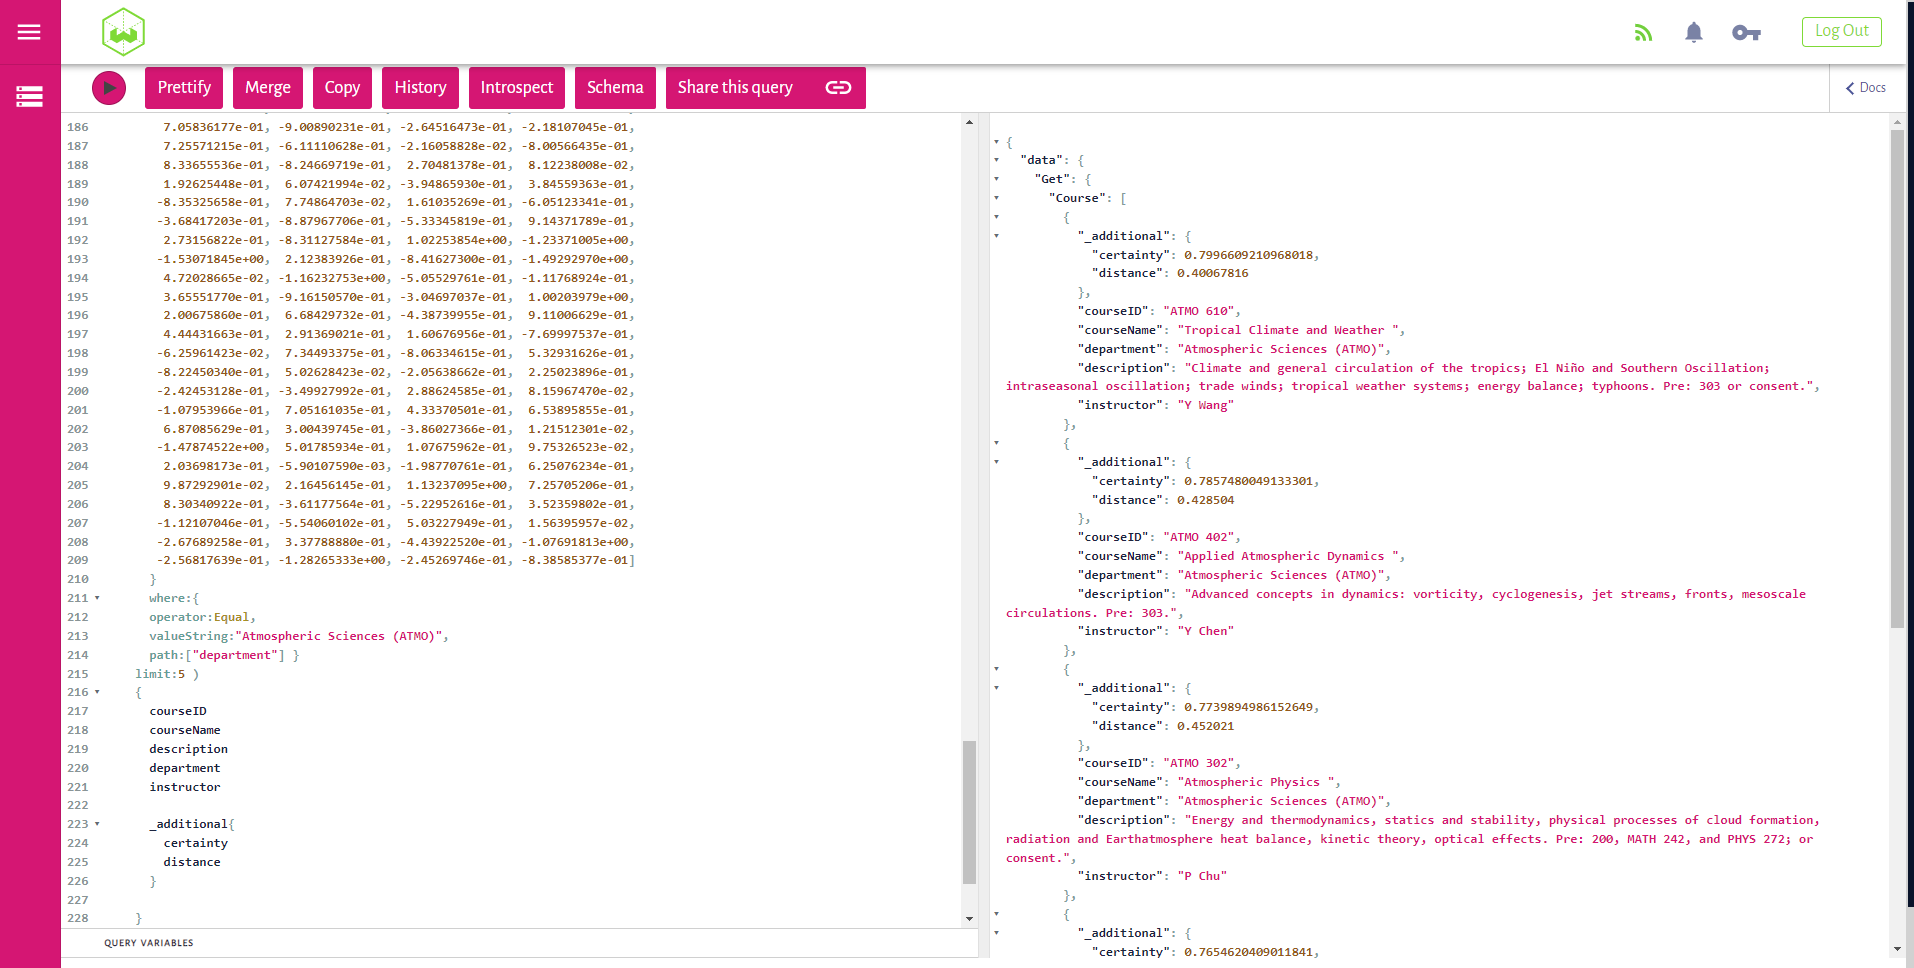

# Visualizations: 
In this section we provide visualizations of our vector embeddings.

## Dimensionality Reduction

As noted above, the model used to create the embeddings produced a 768 dimensional vector for each of the Course objects in the database. In order to visualize the embedding we must perform dimensionality reduction, to view our embeddings in two-dimensional (2-D) and three dimensional (3-D) space. In this section we use three techniques to perform dimensionality reduction: Principal Component Analysis (PCA),  T-distributed stochastic neighbor embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP).



### PCA Visualization

Each technique approaches dimensionality reduction differently. With PCA, the goal is to maximize variance among the components of the data; dissimilar embeddings are kept away from each other, preserving the global structure of the data. The trade-off is that similar embeddings, local structures, could be lost in the analysis.

<b> PCA: 2D

In [ ]:
pca = PCA(n_components=2)
pca_result_2 = pca.fit_transform(course_vecs)

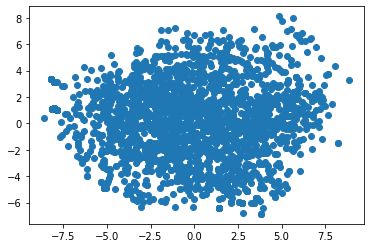

In [ ]:
plt.scatter(pca_result_2[:,0],pca_result_2[:,1])

<b> PCA: 3D

In [ ]:
pca = PCA(n_components=3)
pca_result_3 = pca.fit_transform(course_vecs)

In [ ]:
df = pd.DataFrame()
df['pca-one'] = pca_result_3[:,0]
df['pca-two'] = pca_result_3[:,1] 
df['pca-three'] = pca_result_3[:,2]

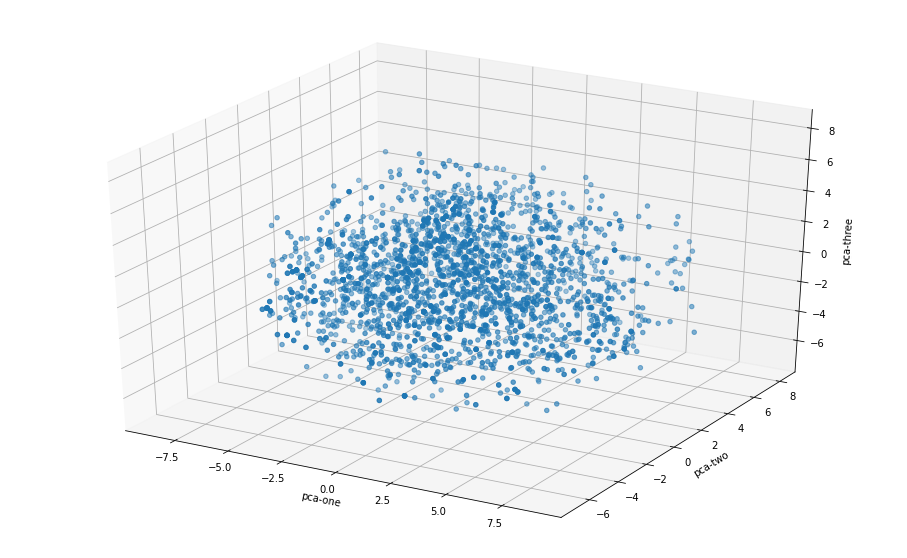

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### t-SNE Visualization

t-SNE on the other hand tries to preserve the local structures, maintaining the relationship/structure between similar embeddings. The approach does not prioritize variance. In our approach we first apply PCA to the embeddings to reduce the 768 dimensions to 50, and then apply t-SNE to reduce the adjusted dimensions to 2D and 3D representations for visualization. Given the trivial size (<10k) of our data set the PCA reduction is not completely necessary in this case, but on larger data sets t-SNE is very slow; for the sake of performance reducing the dimensionality with PCA for dense data is recommended. 

<b> t-SNE: 2D

In [ ]:
pca = PCA(n_components=50)
pca_result_reduction = pca.fit_transform(course_vecs)

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_reduction)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


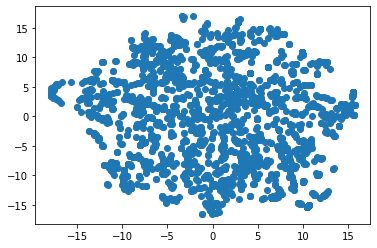

In [ ]:
plt.scatter(tsne_pca_results[:,0],tsne_pca_results[:,1])

<b> t-SNE: 3D

In [ ]:
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results_3 = tsne.fit_transform(pca_result_reduction)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
#df_tsne = pd.DataFrame()
df['tsne-one'] = tsne_pca_results_3[:,0]
df['tsne-two'] = tsne_pca_results_3[:,1] 
df['tsne-three'] = tsne_pca_results_3[:,2]

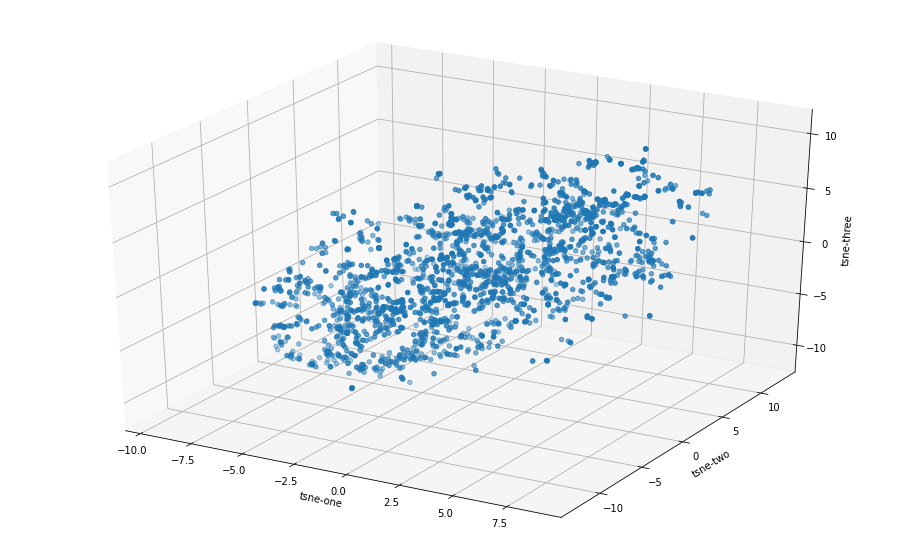

In [ ]:
ax_t = plt.figure(figsize=(16,10)).gca(projection='3d')
ax_t.scatter(
    xs=df.loc[:,:]["tsne-one"], 
    ys=df.loc[:,:]["tsne-two"], 
    zs=df.loc[:,:]["tsne-three"], 
    cmap='tab10'
)
ax_t.set_xlabel('tsne-one')
ax_t.set_ylabel('tsne-two')
ax_t.set_zlabel('tsne-three')
plt.show()

### UMAP Visualization

UMAP is our final application of a dimensionality reduction technique. Similar to t-SNE, UMAP preserves the local structure integrity of similar embeddings. However, UMAP scales much better than t-SNE, handling data without the need for PCA preprocessing and preserves the global structure of the data.


<b> UMAP: 2D

In [ ]:
umap = UMAP(n_components= 2)

In [ ]:
umap_results = umap.fit_transform(course_vecs)

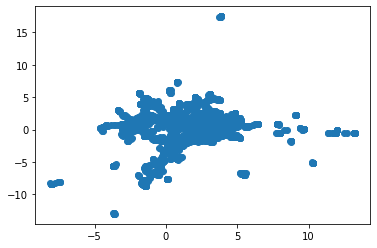

In [ ]:
plt.scatter(umap_results[:,0],umap_results[:,1])

<b> UMAP: 3D

In [ ]:
umap_3 = UMAP(n_components= 3)

In [ ]:
umap_results_3 = umap_3.fit_transform(course_vecs)

In [ ]:

df['umap-one'] = umap_results_3[:,0]
df['umap-two'] = umap_results_3[:,1] 
df['umap-three'] = umap_results_3[:,2]

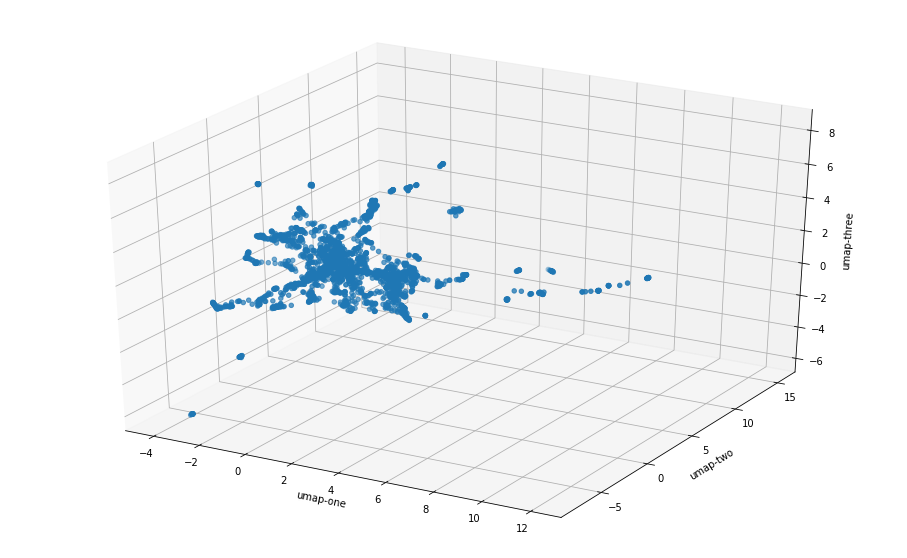

In [ ]:
ax_u = plt.figure(figsize=(16,10)).gca(projection='3d')
ax_u.scatter(
    xs=df.loc[:,:]['umap-one'], 
    ys=df.loc[:,:]['umap-two'], 
    zs=df.loc[:,:]['umap-three'], 
    cmap='tab10'
)
ax_u.set_xlabel('umap-one')
ax_u.set_ylabel('umap-two')
ax_u.set_zlabel('umap-three')
plt.show()

### Visualization Summary




In summary, the 2D and 3D PCA visualization do not provide any real insight on the structure of the embedding data. Groupings (clusters) of courses are mostly indiscernible. t-SNE performs much better than PCA. We can begin to see some distinctions; local clusters appear tighter with some of the global structure remaining intact. Finally, UMAP appears to have performed the best in terms of visualizing some distinct groupings of embeddings, even though there is still a large main component containing the majority of the courses. 

# Conclusion

In this project I’ve explored the relevant architecture of the Weaviate core node, implemented a vector database using Weaviate and applied three dimensionality reduction algorithms to provide 2D and 3D visualization of the vector data. 

The core of this project, the vector database implementation, was the result of thoroughly exploring Weaviate’s extensive [documentation](https://weaviate.io/developers/weaviate/current/), well-curated [blog](https://weaviate.io/blog.html) and active [github](https://github.com/semi-technologies/weaviate) repository. As a nimble and relatively new start-up, I believe Weaviate will continue to innovate in the vector database space, as they prioritize both research and the customer experience. As discussed in the project, Weaviate currently uses a highly performant HNSW implementation of Approximate Nearest Neighbors, and are currently pursuing research to explore other ANN algorithms (i.e. [Vamana](https://weaviate.io/blog/2022/10/ANN-algorithms-Vamana-vs-HNSW.html)) to further improve their product, and reach a goal of 1T. Additionally, Weaviate has released communication around future developments including an Audio2Vec module, BM25 capabilities and improving scalability with replication. 


Weaviate is scheduled to release version `1.17` at the end of 2022.
